# Tutorial on Recognizing Noise in EEG

This notebook provides an interactive introduction to common forms of noise in iEEG signals. We cover 
* Background on the frequency domain and Fourier analysis
* Pink noise (1/f) background spectra
* Common physiological signals (e.g. theta oscillations)
* White noise
* Line noise
* Structure of Artifacts Across Channels
* Denoising Strategies


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import scipy
from scipy import stats
import pandas as pd
import mne

from eegsim import EEGGen

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload
%autoreload 2
from utils import generate_eeg_events, plot_time, plot_psd, plot_eeg_signal

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## A Brief Introduction to the Frequency Domain and Fourier Analysis

Fourier analysis comprises a set of methods for representing a time domain series, such as an EEG trace, in the frequency domain. Every time domain signal has a frequency domain representation in which the time domain series is decomposed into a series of sinusoids. This frequency domain representation under certain assumptions exactly represents the time domain representation with no loss of information. Before we dive in fully, we note that the field of Fourier analysis is vast, and this introduction is brief and meant to provide a baseline intuition needed for interpreting frequency domain representations. For more information, see Michael Kahana's textbook "Electrophysiology of Human Memory" or Wikipedia.

For a periodic signal (of infinite length), the frequency domain representation is a sum of sinusoids (sines and cosines) at integer multiples of the fundamental frequency of the periodic signal (f = 1/period). For aperiodic signals, the frequency domain representation is a sum of sinusoids across a continuous range of frequencies.

The frequency domain representation contains two sets of information: amplitude information (how far up and down the sinusoidal components oscillate) and phase information (how the sinusoidal components are offset relative to each other). For the purposes of debugging EEG signal quality, we will usually care mostly about the amplitude information. We'll represent the amplitude information as the power spectral density (PSD), which gives the amount of signal power at some frequency (technically, per unit frequency). The power of a signal at some frequency is its amplitude magnitude at that frequency squared.

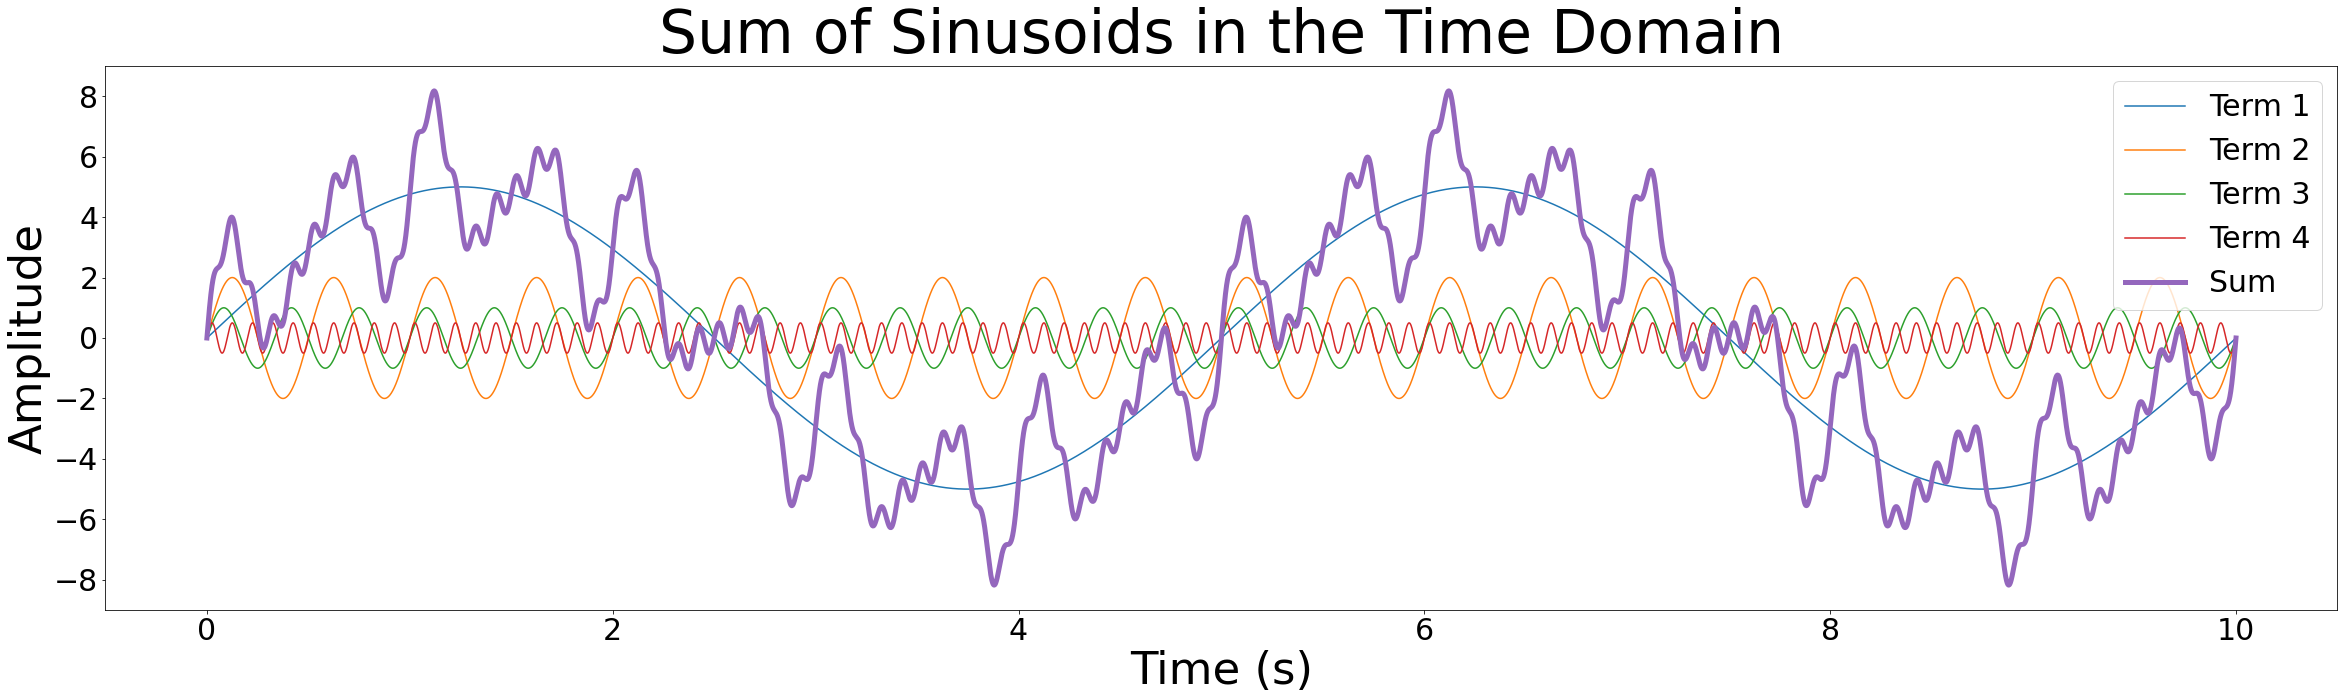

In [2]:
sample_rate = 10000  # Hz
duration = 10

# give Wikipedia references to common Fourier transforms for the interested

# generate sum of sinusoids

t = np.linspace(0, duration, sample_rate * duration)
s = np.zeros_like(t)
components = dict()

# component 1
amp = 5
freq = 0.2
offset = 0.0
components[1] = amp * np.sin(2*np.pi*freq * (t - offset))

# component 2
amp = 2  # amplitude
freq = 2  # frequency in Hz or oscillatory cycles per second
offset = 0.0  # offset of sinusoidal component in seconds
components[2] = amp * np.sin(2*np.pi*freq * (t - offset))

# component 3
amp = 1
freq = 3
offset = 0.0
components[3] = amp * np.sin(2*np.pi*freq * (t - offset))

# component 4
amp = 0.5
freq = 10
offset = 0.0
components[4] = amp * np.sin(2*np.pi*freq * (t - offset))

plt.figure(figsize=(40, 10))

# plot components
for i, c in components.items():
    s += c
    plt.plot(t, c, label=f'Term {i}')    
# plot sum
plt.plot(t, s, label='Sum', linewidth=5)

plt.xlabel('Time (s)', fontsize=45)
plt.ylabel('Amplitude', fontsize=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Sum of Sinusoids in the Time Domain', fontsize=60)
_ = plt.legend(fontsize=30)

That sum of sinusoids is fairly complex (starting to look a little like EEG!), with the different sinusoidal components being hard to tell apart. However, in the frequency domain, each of the sinusoidal components becomes easily distinguishable. To go from the time domain to the frequency domain, we use the Fourier transform.

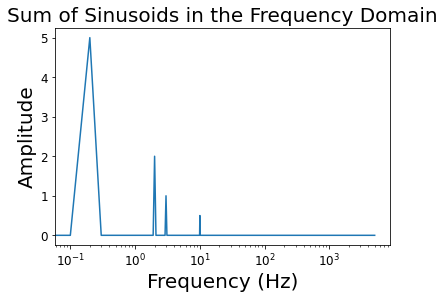

In [3]:
# plot the frequency domain representation of the sum of sinusoids
from scipy.fft import fft, fftfreq, ifft
freqs = np.linspace(0, sample_rate / 2, 1000)

# get the Fourier transform with the Fast Fourier Transform (FFT) algorithm
s_freq = fft(s)
N = sample_rate * duration
freqs = fftfreq(N, 1/sample_rate)[:N//2]
# transform from complex-valued frequency representation to absolute magnitudes
s_freq_amp = 2.0/N * np.abs(s_freq[0:N//2])

plt.figure()
# plot frequency on a logarithmic axis for easy visualization
plt.semilogx(freqs, s_freq_amp)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
_ = plt.title('Sum of Sinusoids in the Frequency Domain', fontsize=20)

The sinusoidal components are represented as separate points in the frequency domain. The components as separate peaks at their respective frequencies with the amplitudes the components were assigned. The frequency domain representation makes recognizing common noise signals, such as line noise (discussed later on), much easier than the time domain. Although in practice clinical testers will commonly have access to time domain signals (i.e., raw EEG traces) for debugging, learning to think in terms of the frequency domain will be helpful for debugging noise in EEG.

To go back to the time domain, we apply the inverse Fourier transform to the frequency domain representation of the signal.

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


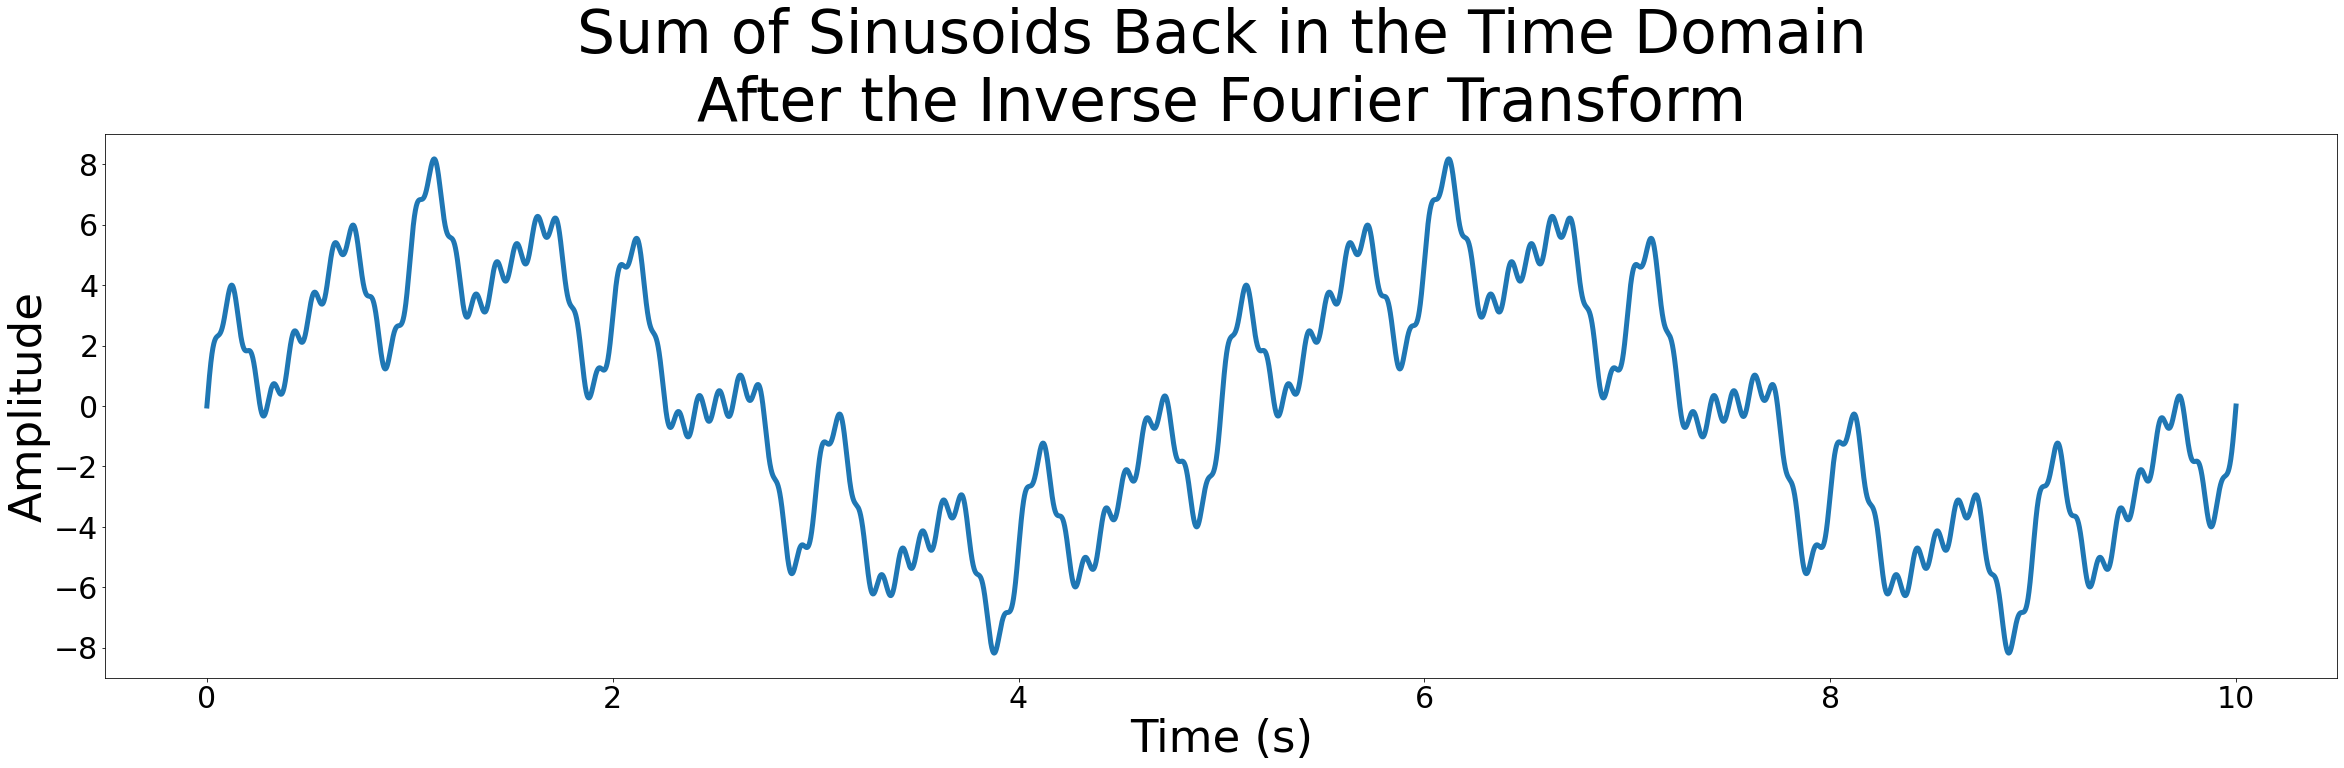

In [4]:
s_inverse = ifft(s_freq)

plt.figure(figsize=(40, 10))
plt.plot(t, s_inverse, label='Sum', linewidth=5)
plt.xlabel('Time (s)', fontsize=45)
plt.ylabel('Amplitude', fontsize=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
_ = plt.title('Sum of Sinusoids Back in the Time Domain\nAfter the Inverse Fourier Transform', fontsize=60)


The square wave is a good illustration of the Fourier series decomposition. While the square wave has sharp edges, it can be represented approximately as a finite sum of smooth sinusoids (with a perfect representation requiring an infinite sum of sinusoids).

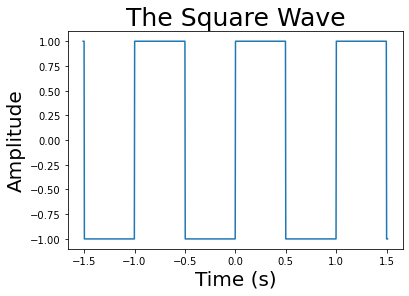

In [5]:
def square_wave(t, period=1.0, offset=0.0):
    half = period / 2
    return 1.0 - 2.0 * np.floor(((t - offset) / half) % 2)

t = np.linspace(-1.51, 1.51, 1000)
plt.plot(t, square_wave(t))
plt.title('The Square Wave', fontsize=25)
plt.xlabel('Time (s)', fontsize=20)
_ = plt.ylabel('Amplitude', fontsize=20)

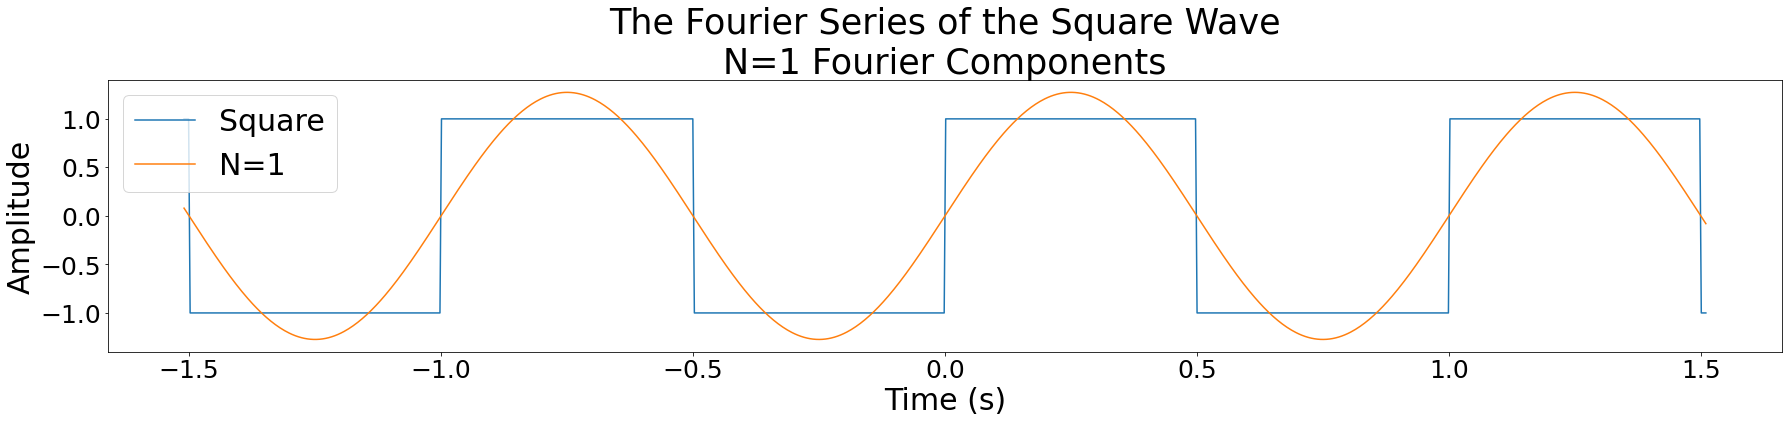

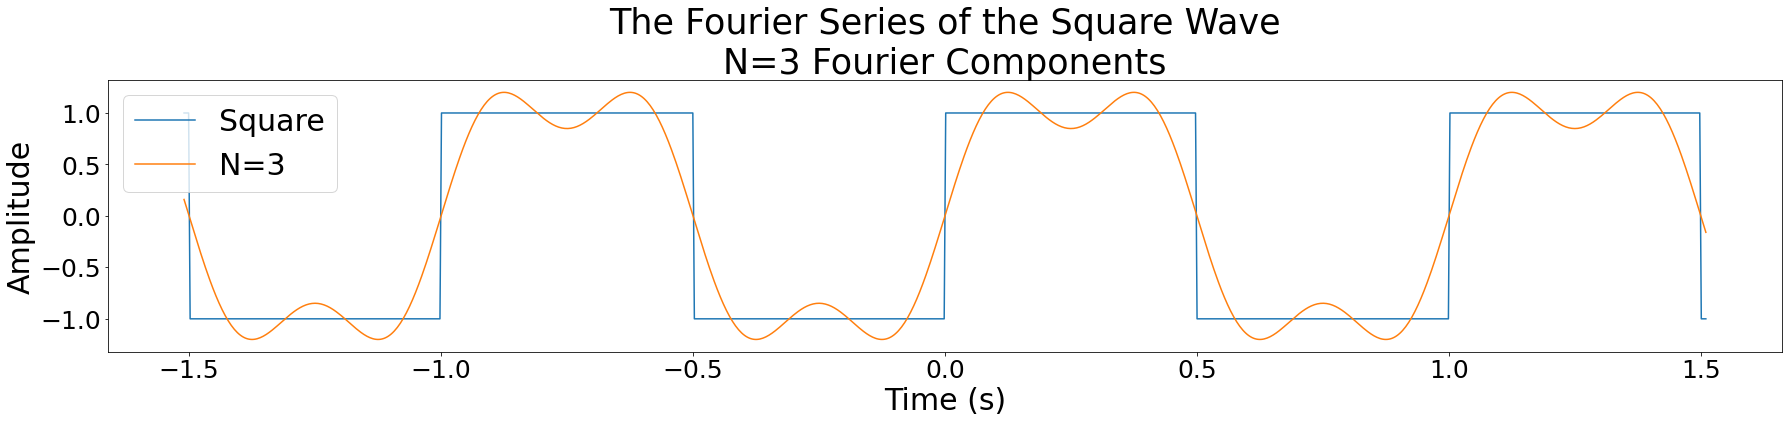

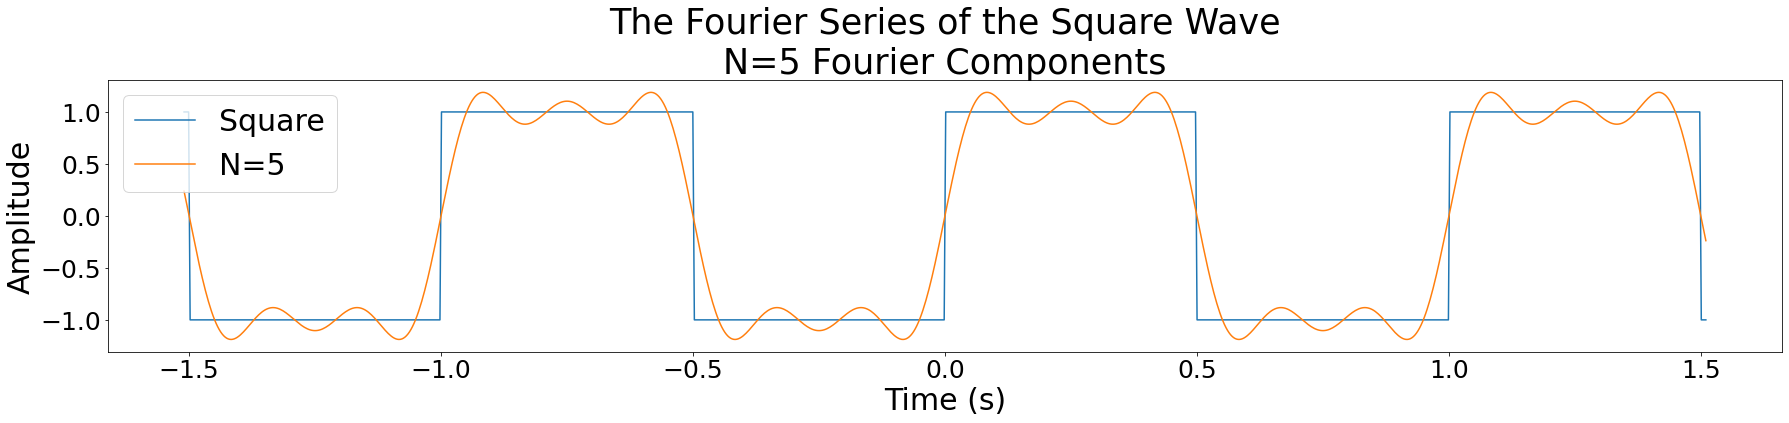

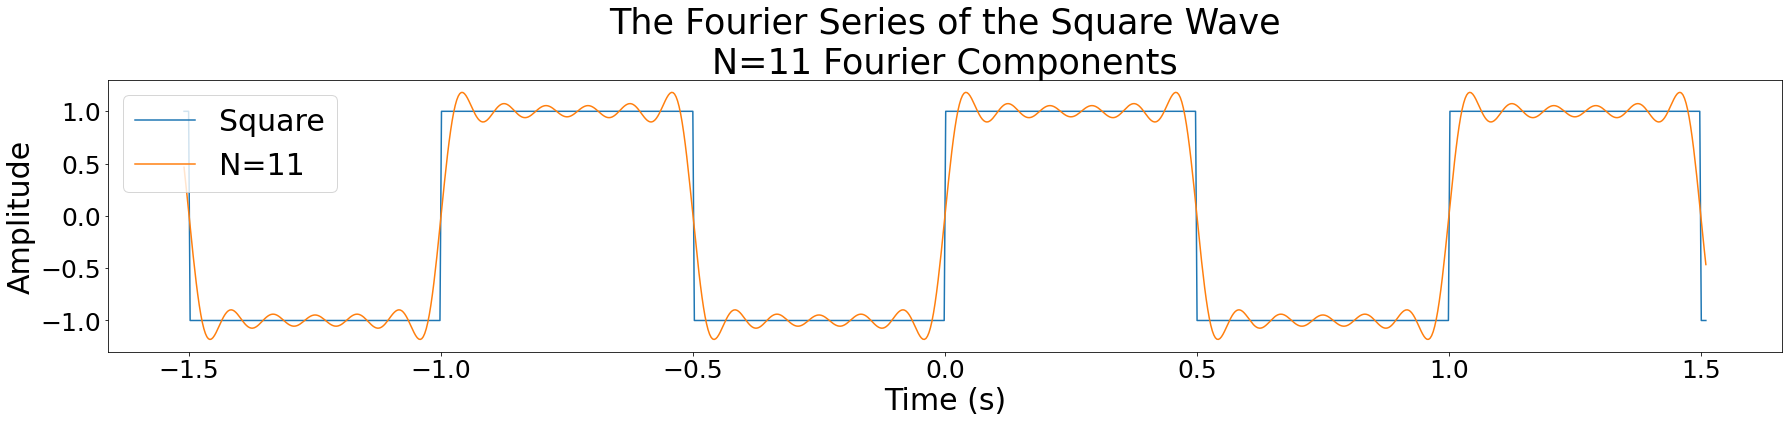

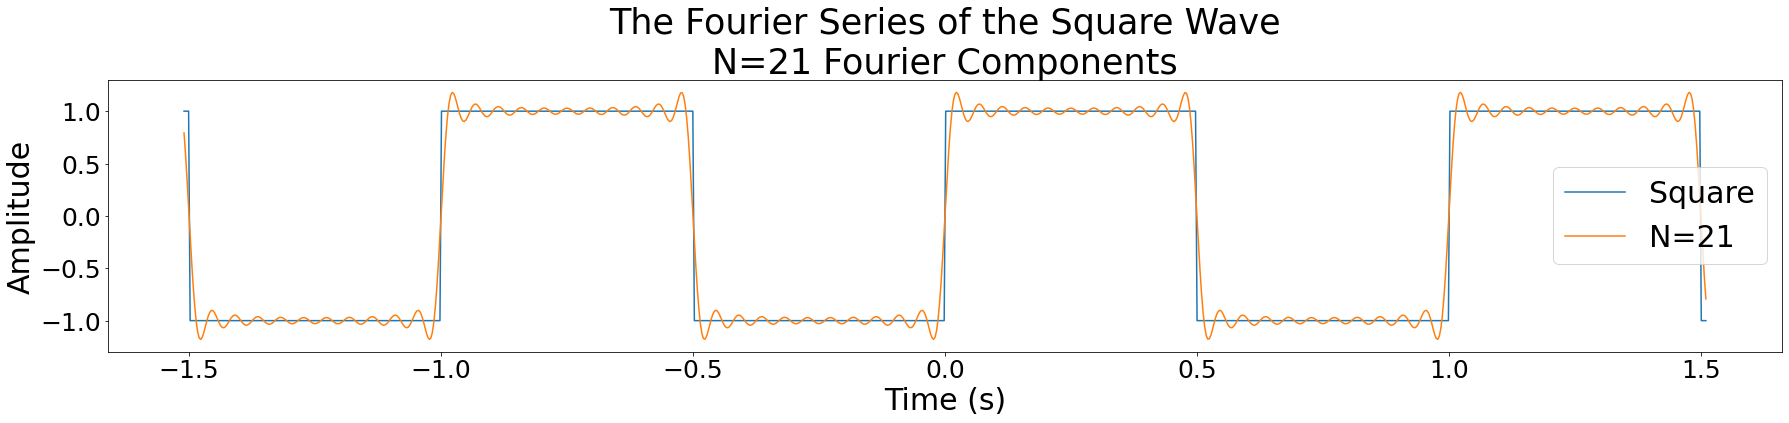

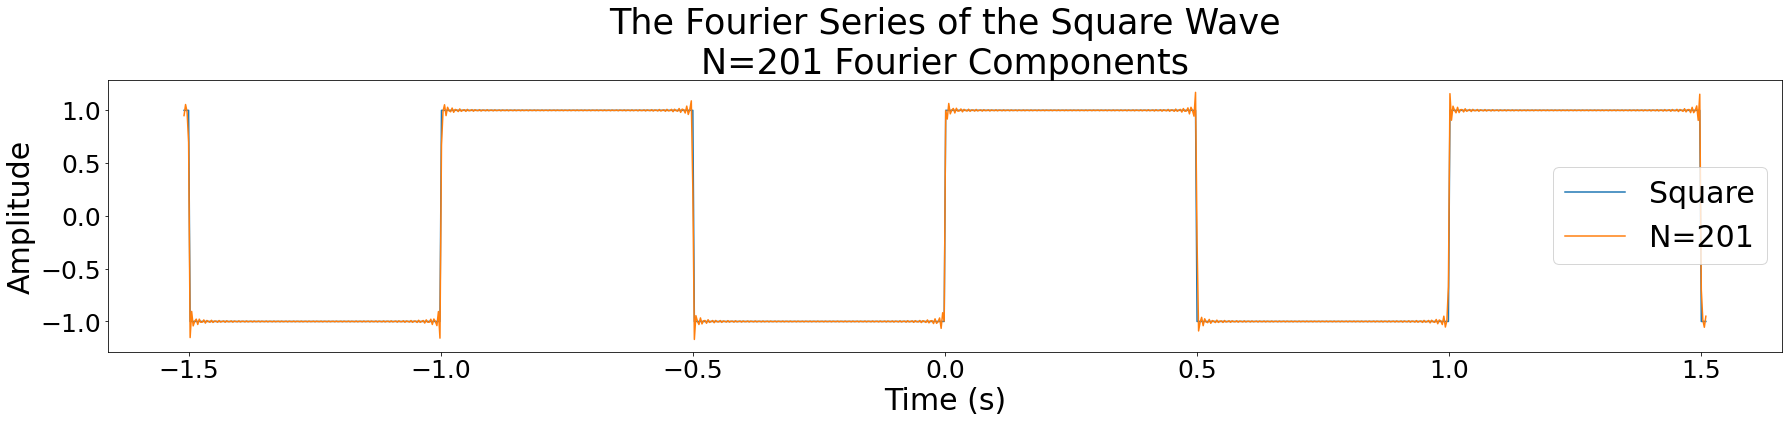

In [6]:
def get_fourier_square_series(t, n=5, period=1.0, offset=0.0):
    series = np.zeros_like(t)
    f = 1.0/period
    t_offset = t - offset
    for i in range(1, n + 1):
        if not (i % 2): bn = 0
        else: bn = 4.0/(i * np.pi)
        series += bn * np.sin(2.0 * np.pi * f * t_offset * i)
    return series

ns = [1, 3, 5, 11, 21, 201]
for n in ns:
    plt.figure(figsize=(30, 5))
    plt.plot(t, square_wave(t), label='Square')
    plt.plot(t, get_fourier_square_series(t, n=n), label=f'N={n}')
    plt.title(f'The Fourier Series of the Square Wave\nN={n} Fourier Components', 
              fontsize=35)
    plt.xlabel('Time (s)', fontsize=30)
    plt.ylabel('Amplitude', fontsize=30)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=30)

## Common EEG Components and Noise Signals

Electrophysiological analysis commonly occurs in the frequency domain. Noise signals present in EEG recordings can be understood in the frequency domain, even if an analyst is looking at the signals in the time domain. Here we show common components of noise in EEG in both the time domain and the frequency domain.

### Pink noise

Pink noise or 1/f noise forms the background signal of the brain. Pink noise signals or 1/f spectra are observed across a wide range of domains, including the modeling of financial markets, the distribution of sound intensity in music, and human psychophysical estimates and response times (http://www.scholarpedia.org/article/1/f_noise). The underlying mathematical principle linking these phenomena is the notion of auto-correlation: auto-correlated signals are correlated with themselves over time. This means that knowing the past value of a pink noise signal is useful for predicting what value the signal will take in the near future.

Pink noise will show up in the power spectra as a decreasing linear function of frequency on a log-log plot. This indicates that pink noise has more signal power at lower frequencies than at higher frequencies. In the time domain, higher low frequency power means that pink noise or 1/f spectra will undulate (slowly rise and fall) with weaker higher frequency content riding over the top of these lower frequency oscillations. Given this slow undulation, or rising and falling, values of pink noise signals nearby in time are more likely to be similar to each other than values that are far away in time (which is another way of saying pink noise signals are autocorrelated).

Pink noise will be a dominant component in clean EEG. Pink noise is arhythmic or aperiodic (it rises and falls without a regular rhythm, at all frequencies or scales of oscillation). Normal EEG will generally exhibit this arhythmicity, although it will sometimes exhibit temporary regular oscillations for a few seconds at time.

1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
LinregressResult(slope=-6.3917189141402995, intercept=26.45725775428145, rvalue=-0.7142474226136372, pvalue=4.360034136614989e-124, stderr=0.2232613007109332, intercept_stderr=0.4309073305043474)


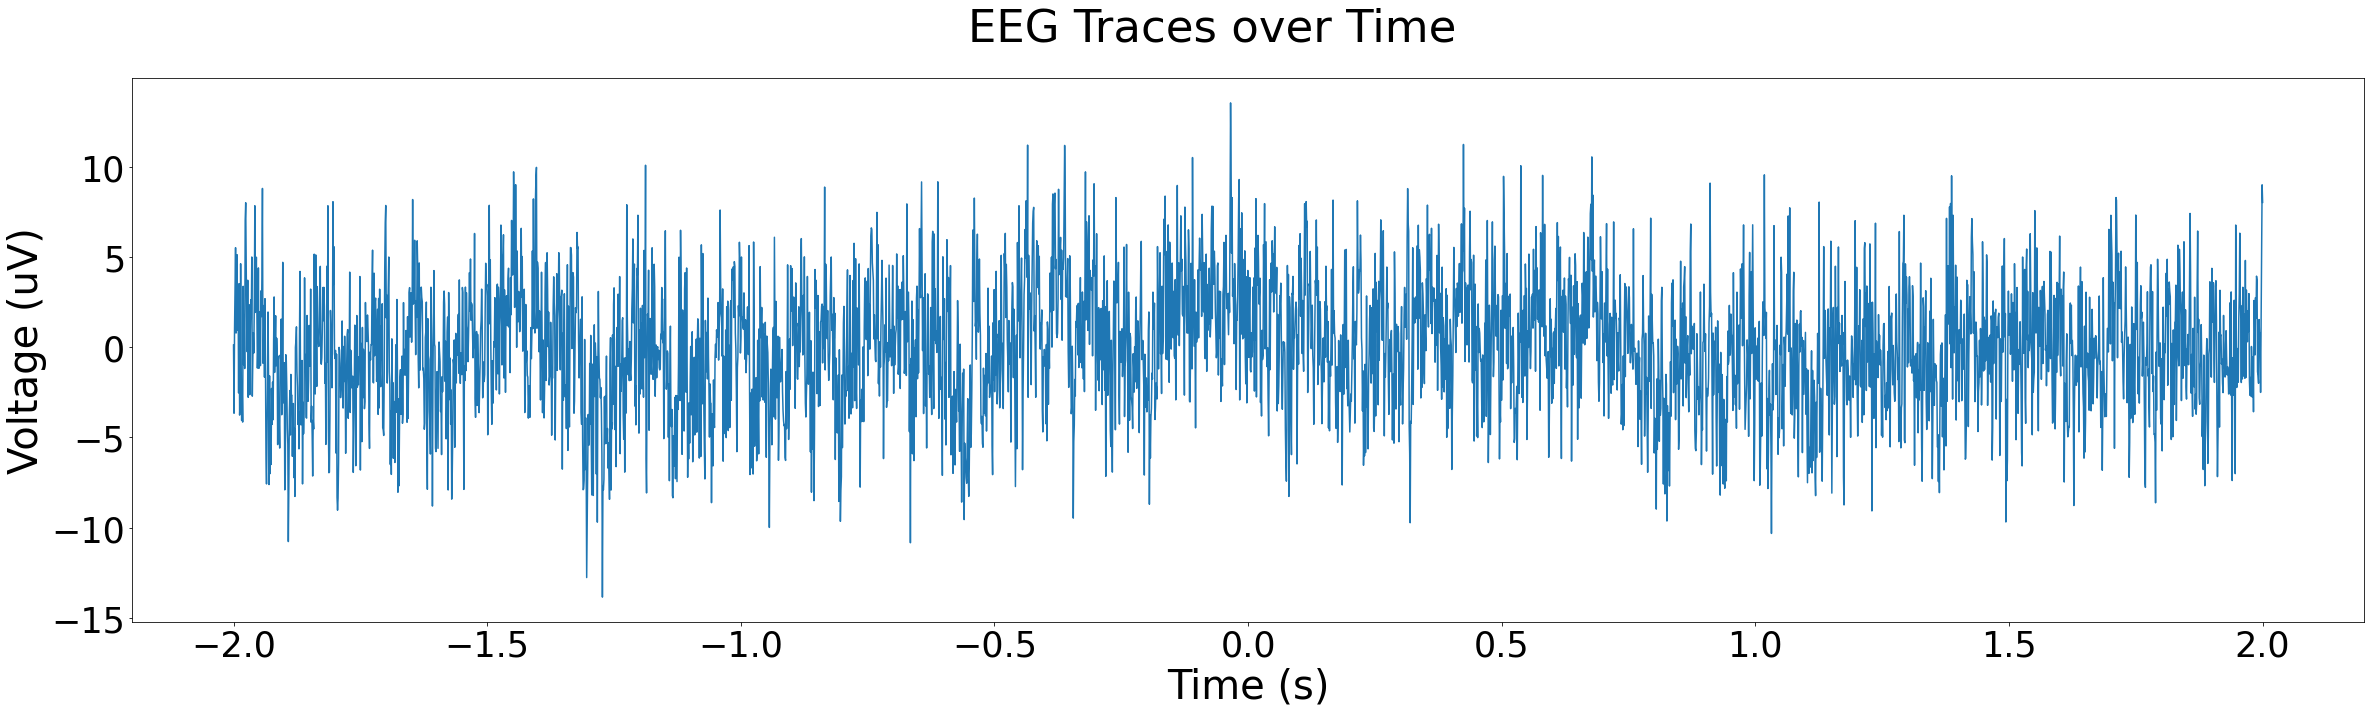

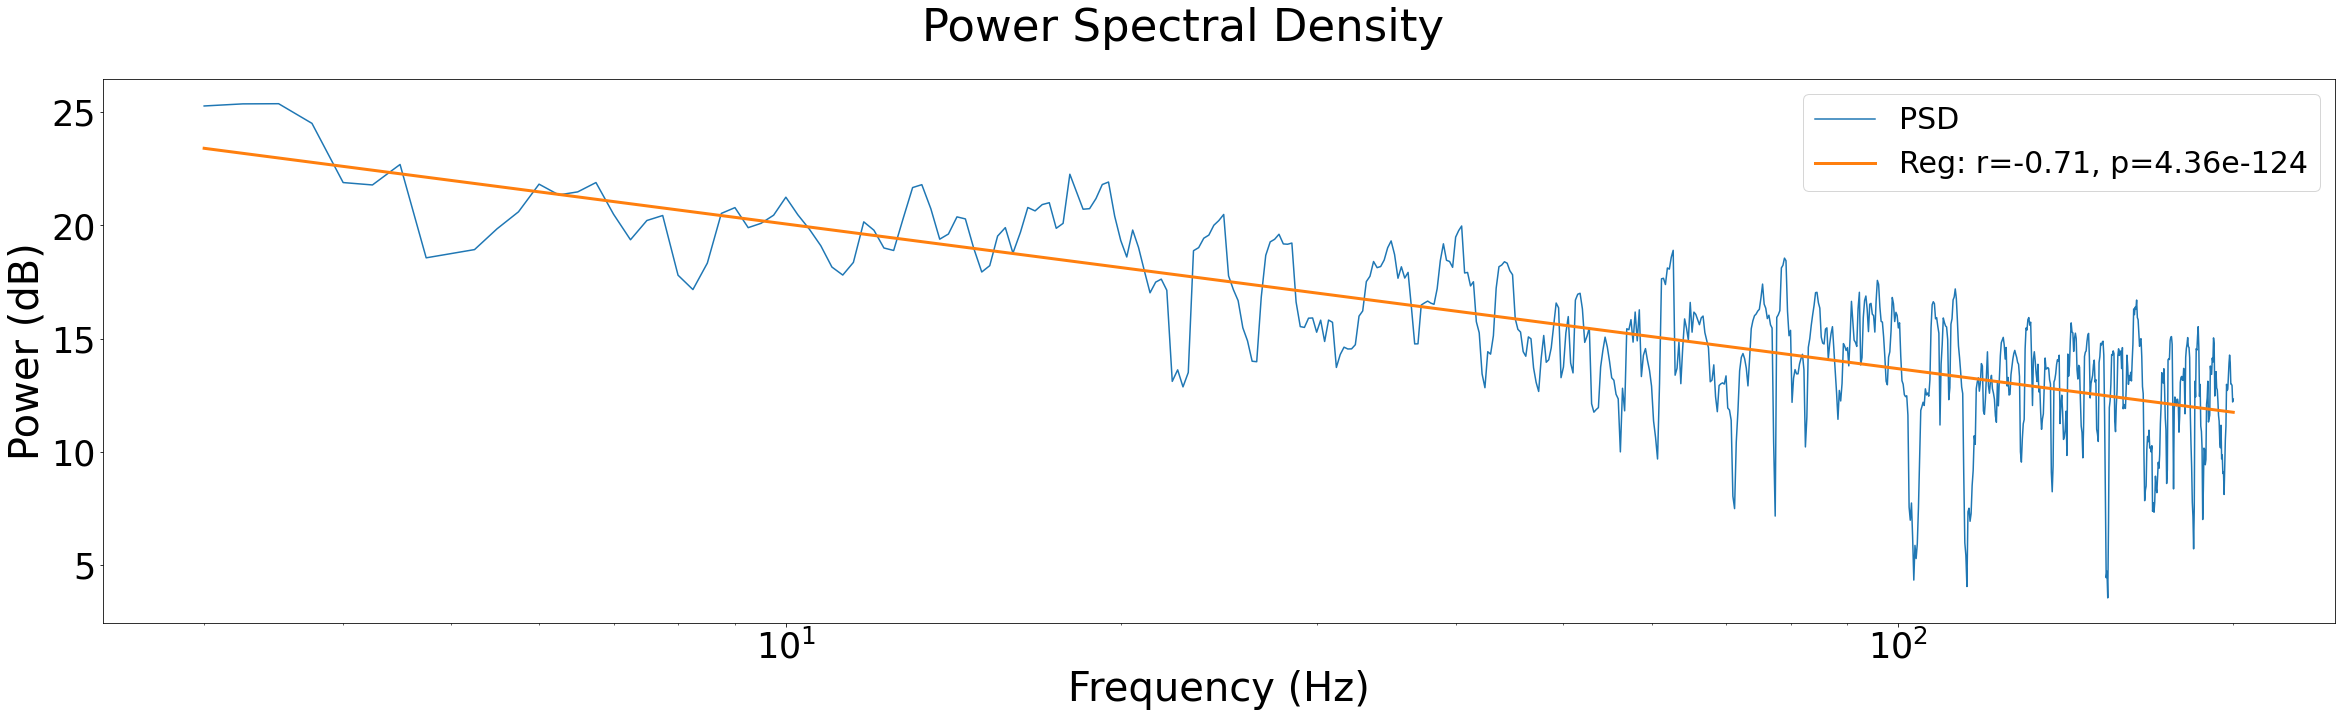

In [7]:
# generate pink noise

eeg_scale = 7  # uV
sample_rate = 1000  # Hz
duration = 4
n_events = 1

# EEG generator instance
gen = EEGGen(sampling_rate=sample_rate)

# Set the pink noise amplitude.
pink_scale = 0.5
pink_exponent = 0.51  #0.51
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)
_ = plot_eeg_signal(gen, duration=duration, n_events=n_events, sample_rate=sample_rate)

The pink noise spectrum will often be accompanied by a (weak) theta oscillation, which will show up as a bump in the theta band (4 - 8 Hz) on top of the pink noise background spectrum.

1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
LinregressResult(slope=-5.9380724722629985, intercept=25.791312715794998, rvalue=-0.6612322480012401, pvalue=2.4465861464239193e-100, stderr=0.24014320882477524, intercept_stderr=0.4634903976816458)


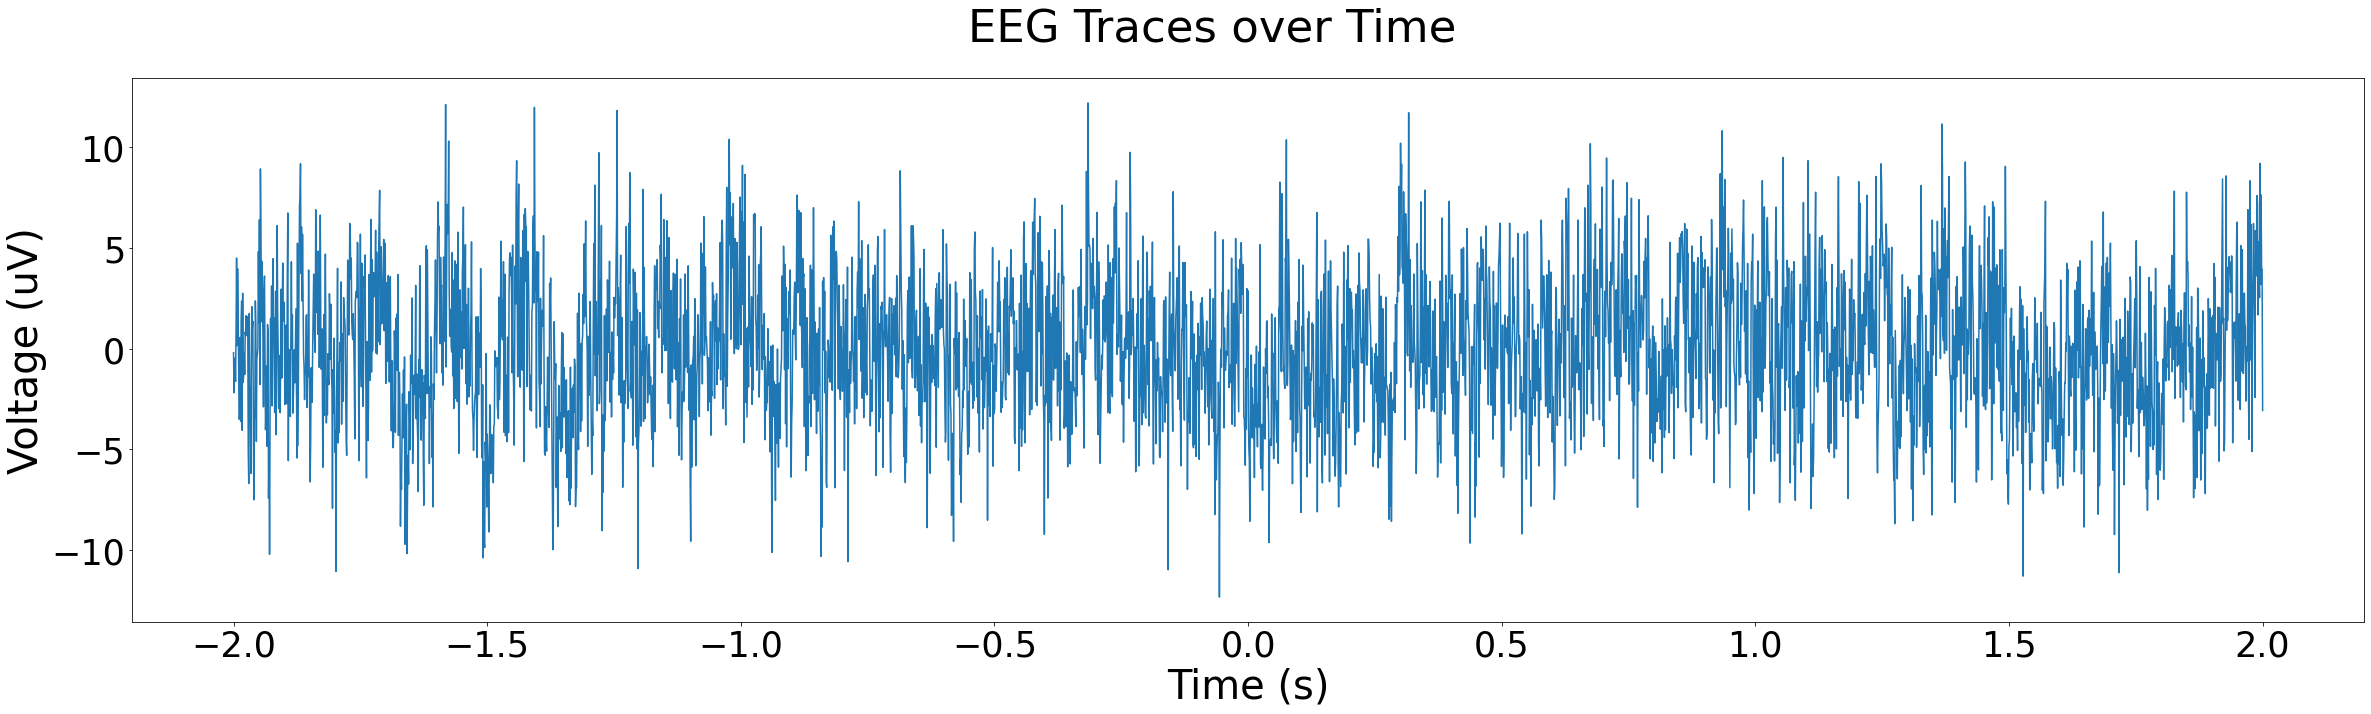

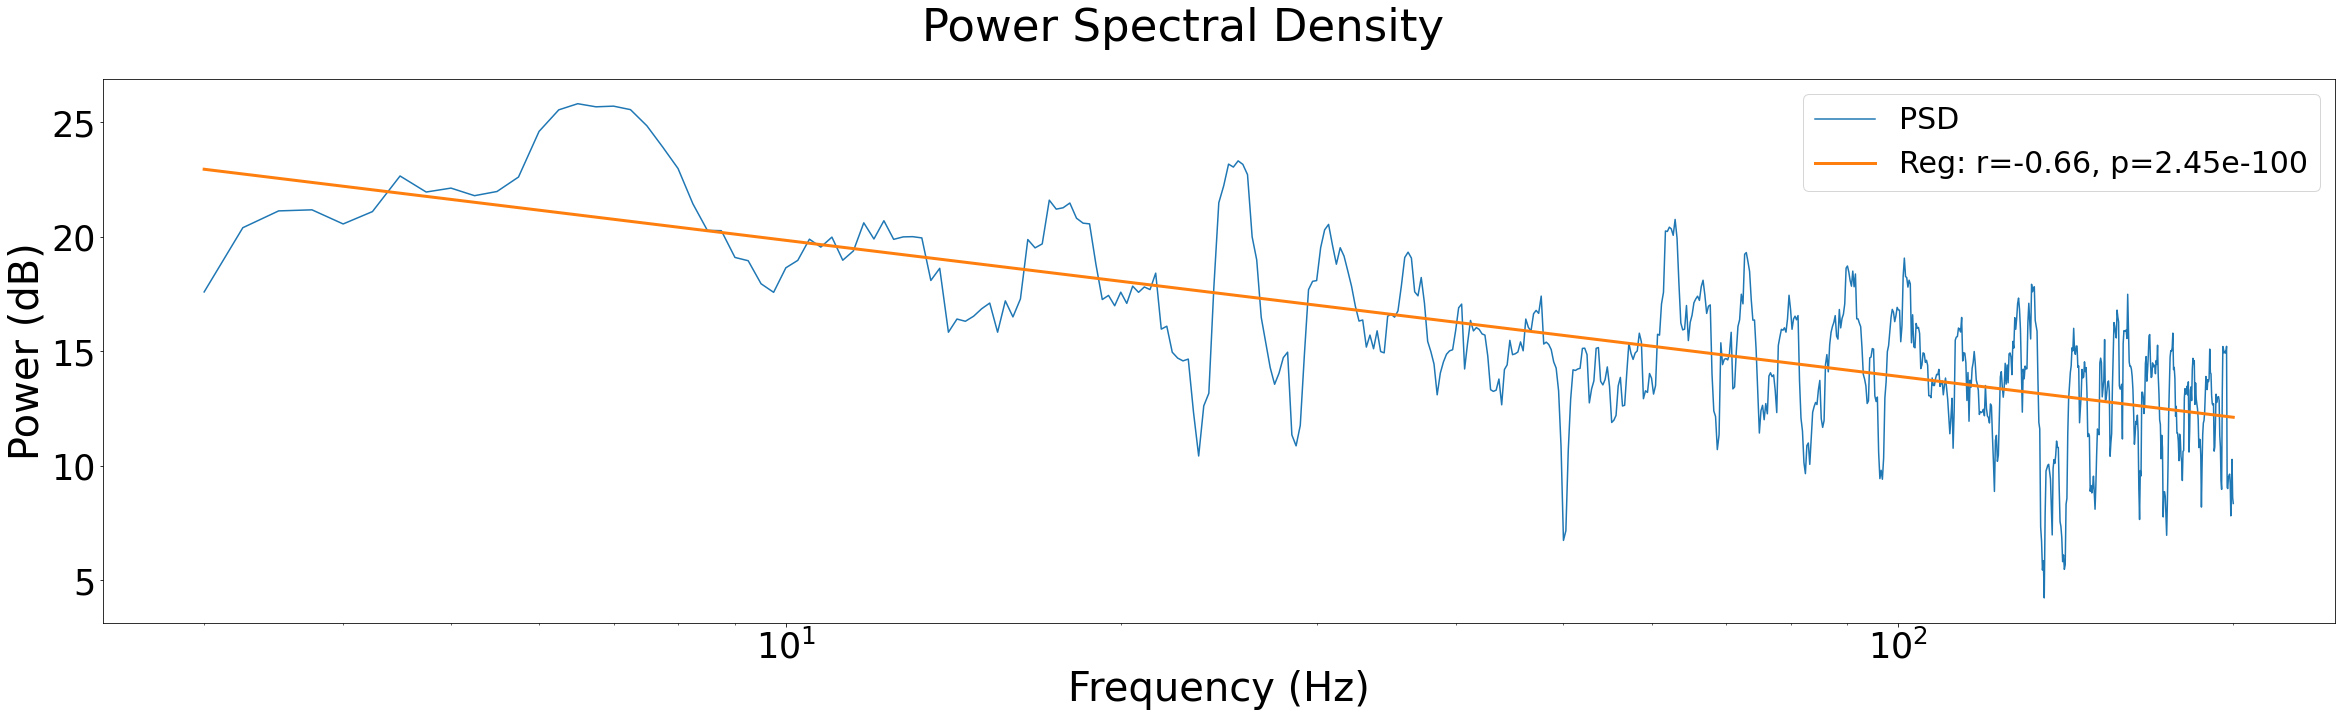

In [8]:
# pink noise with theta oscillation

gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

# add (sinusoidal) oscillatory bout
# Note:  Generator time starts from 0.
osc_freq = 7  # Hz
osc_amplitude_scale = 0.35
osc_offset = 0.25
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=3)

plot_eeg_signal(gen, n_events=1, duration=duration)

### White noise:

White noise, in contrast to pink noise, is not auto-correlated. This implies white noise signals will slowly rise and fall far less than pink noise signals, indicative of no dependence on nearby times. White noise has even or flat power across frequencies and can caused by electrical noise, potentially from a poor connection.
* For EEG troubleshooting, white noise signals due to poorly connected or disconnected cables will often be seen with a different signal scale or variability. I.e., the range of signal values will fall out of the 1-10 uV range typical for clean EEG.

1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
LinregressResult(slope=0.6426835349689527, intercept=12.055563097926152, rvalue=0.09811966538512881, pvalue=0.00580875124419344, stderr=0.23235554566169178, intercept_stderr=0.44845975361666207)


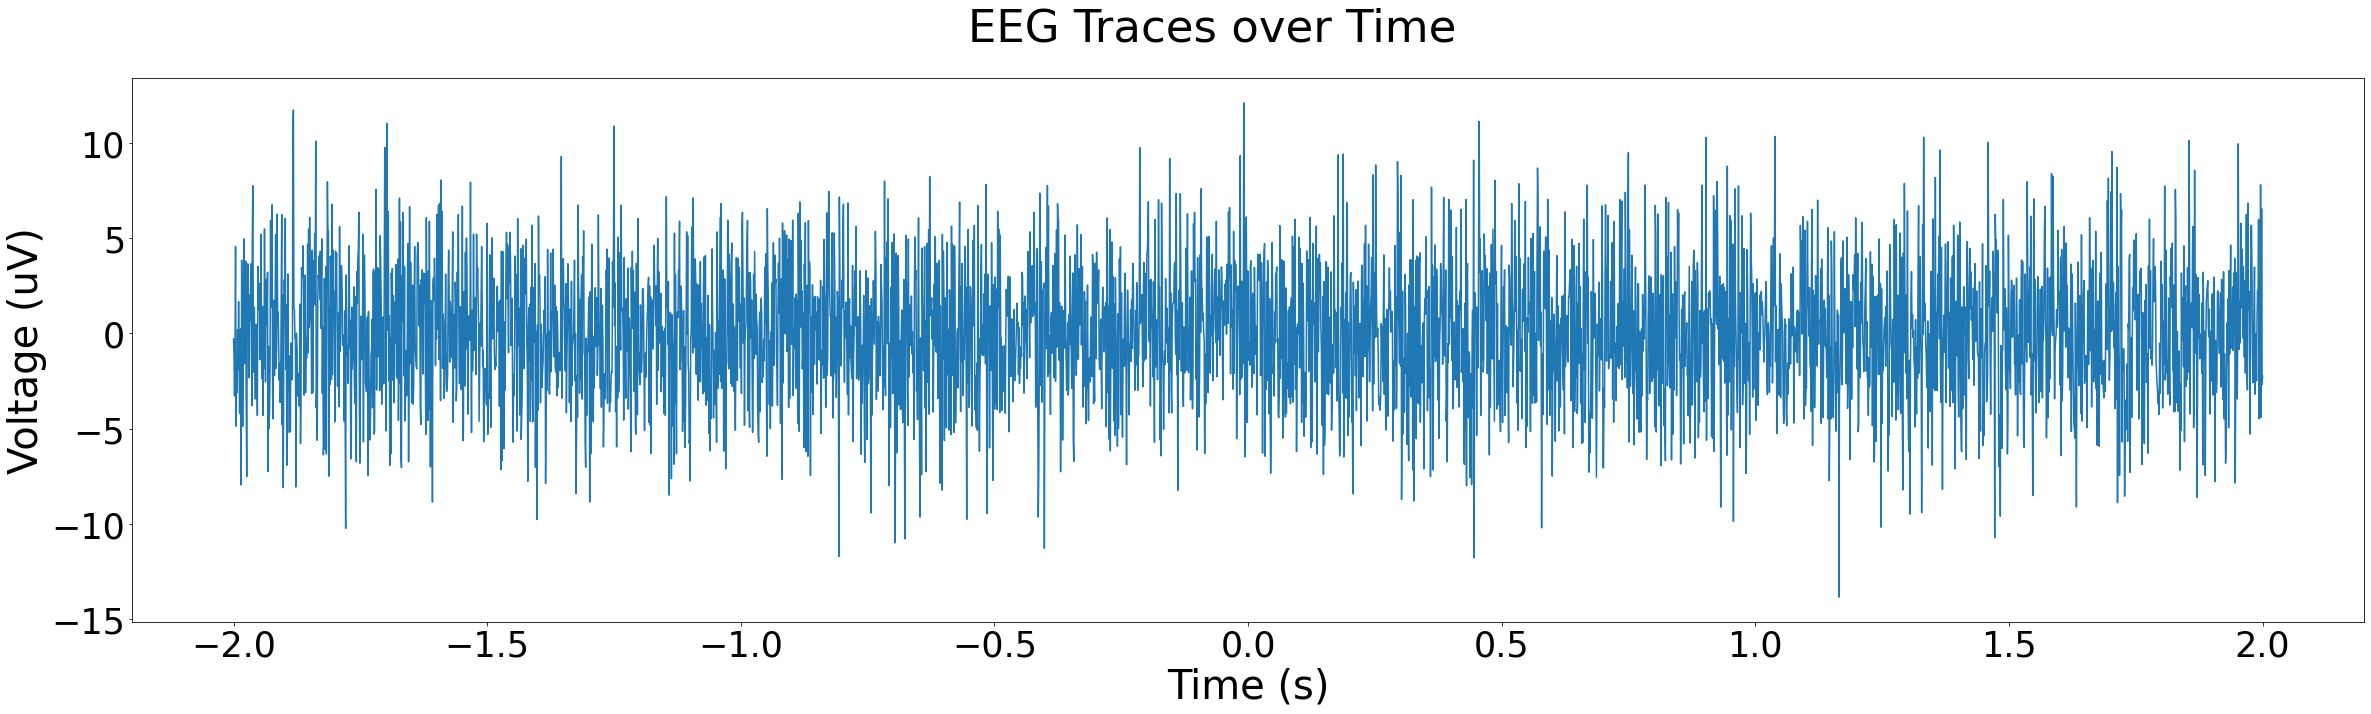

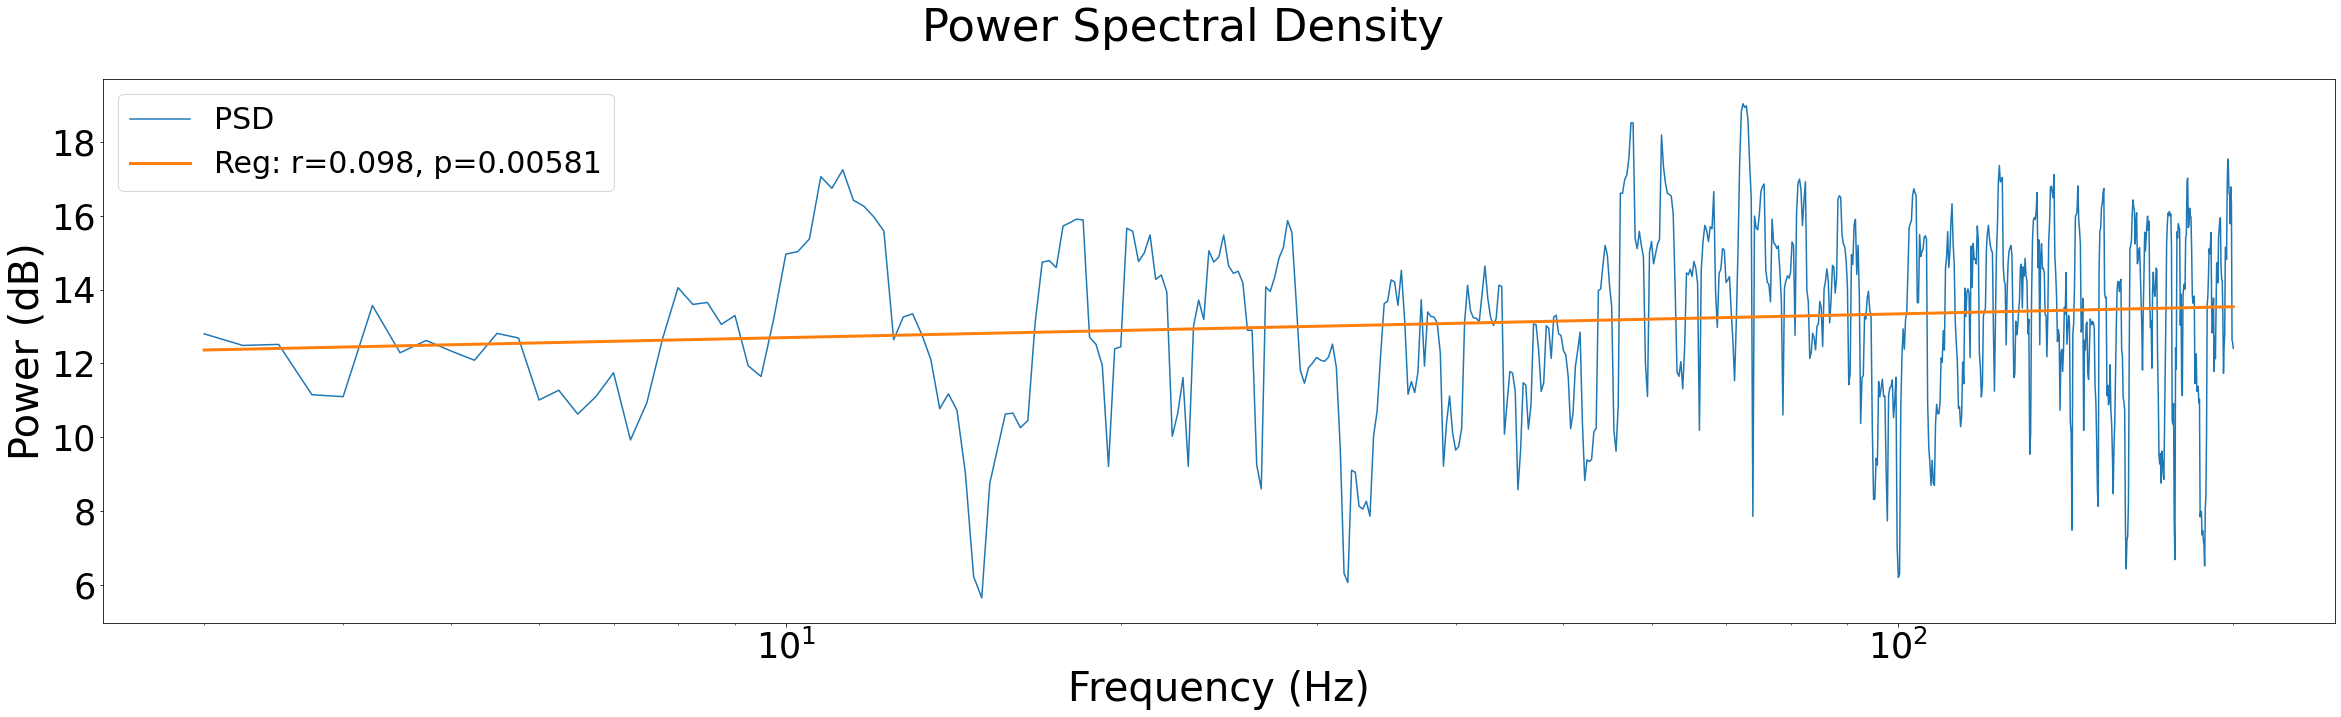

In [9]:
# generate white noise
gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.0
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

plot_eeg_signal(gen, duration=duration, n_events=1)

Compare white and pink noise side by side

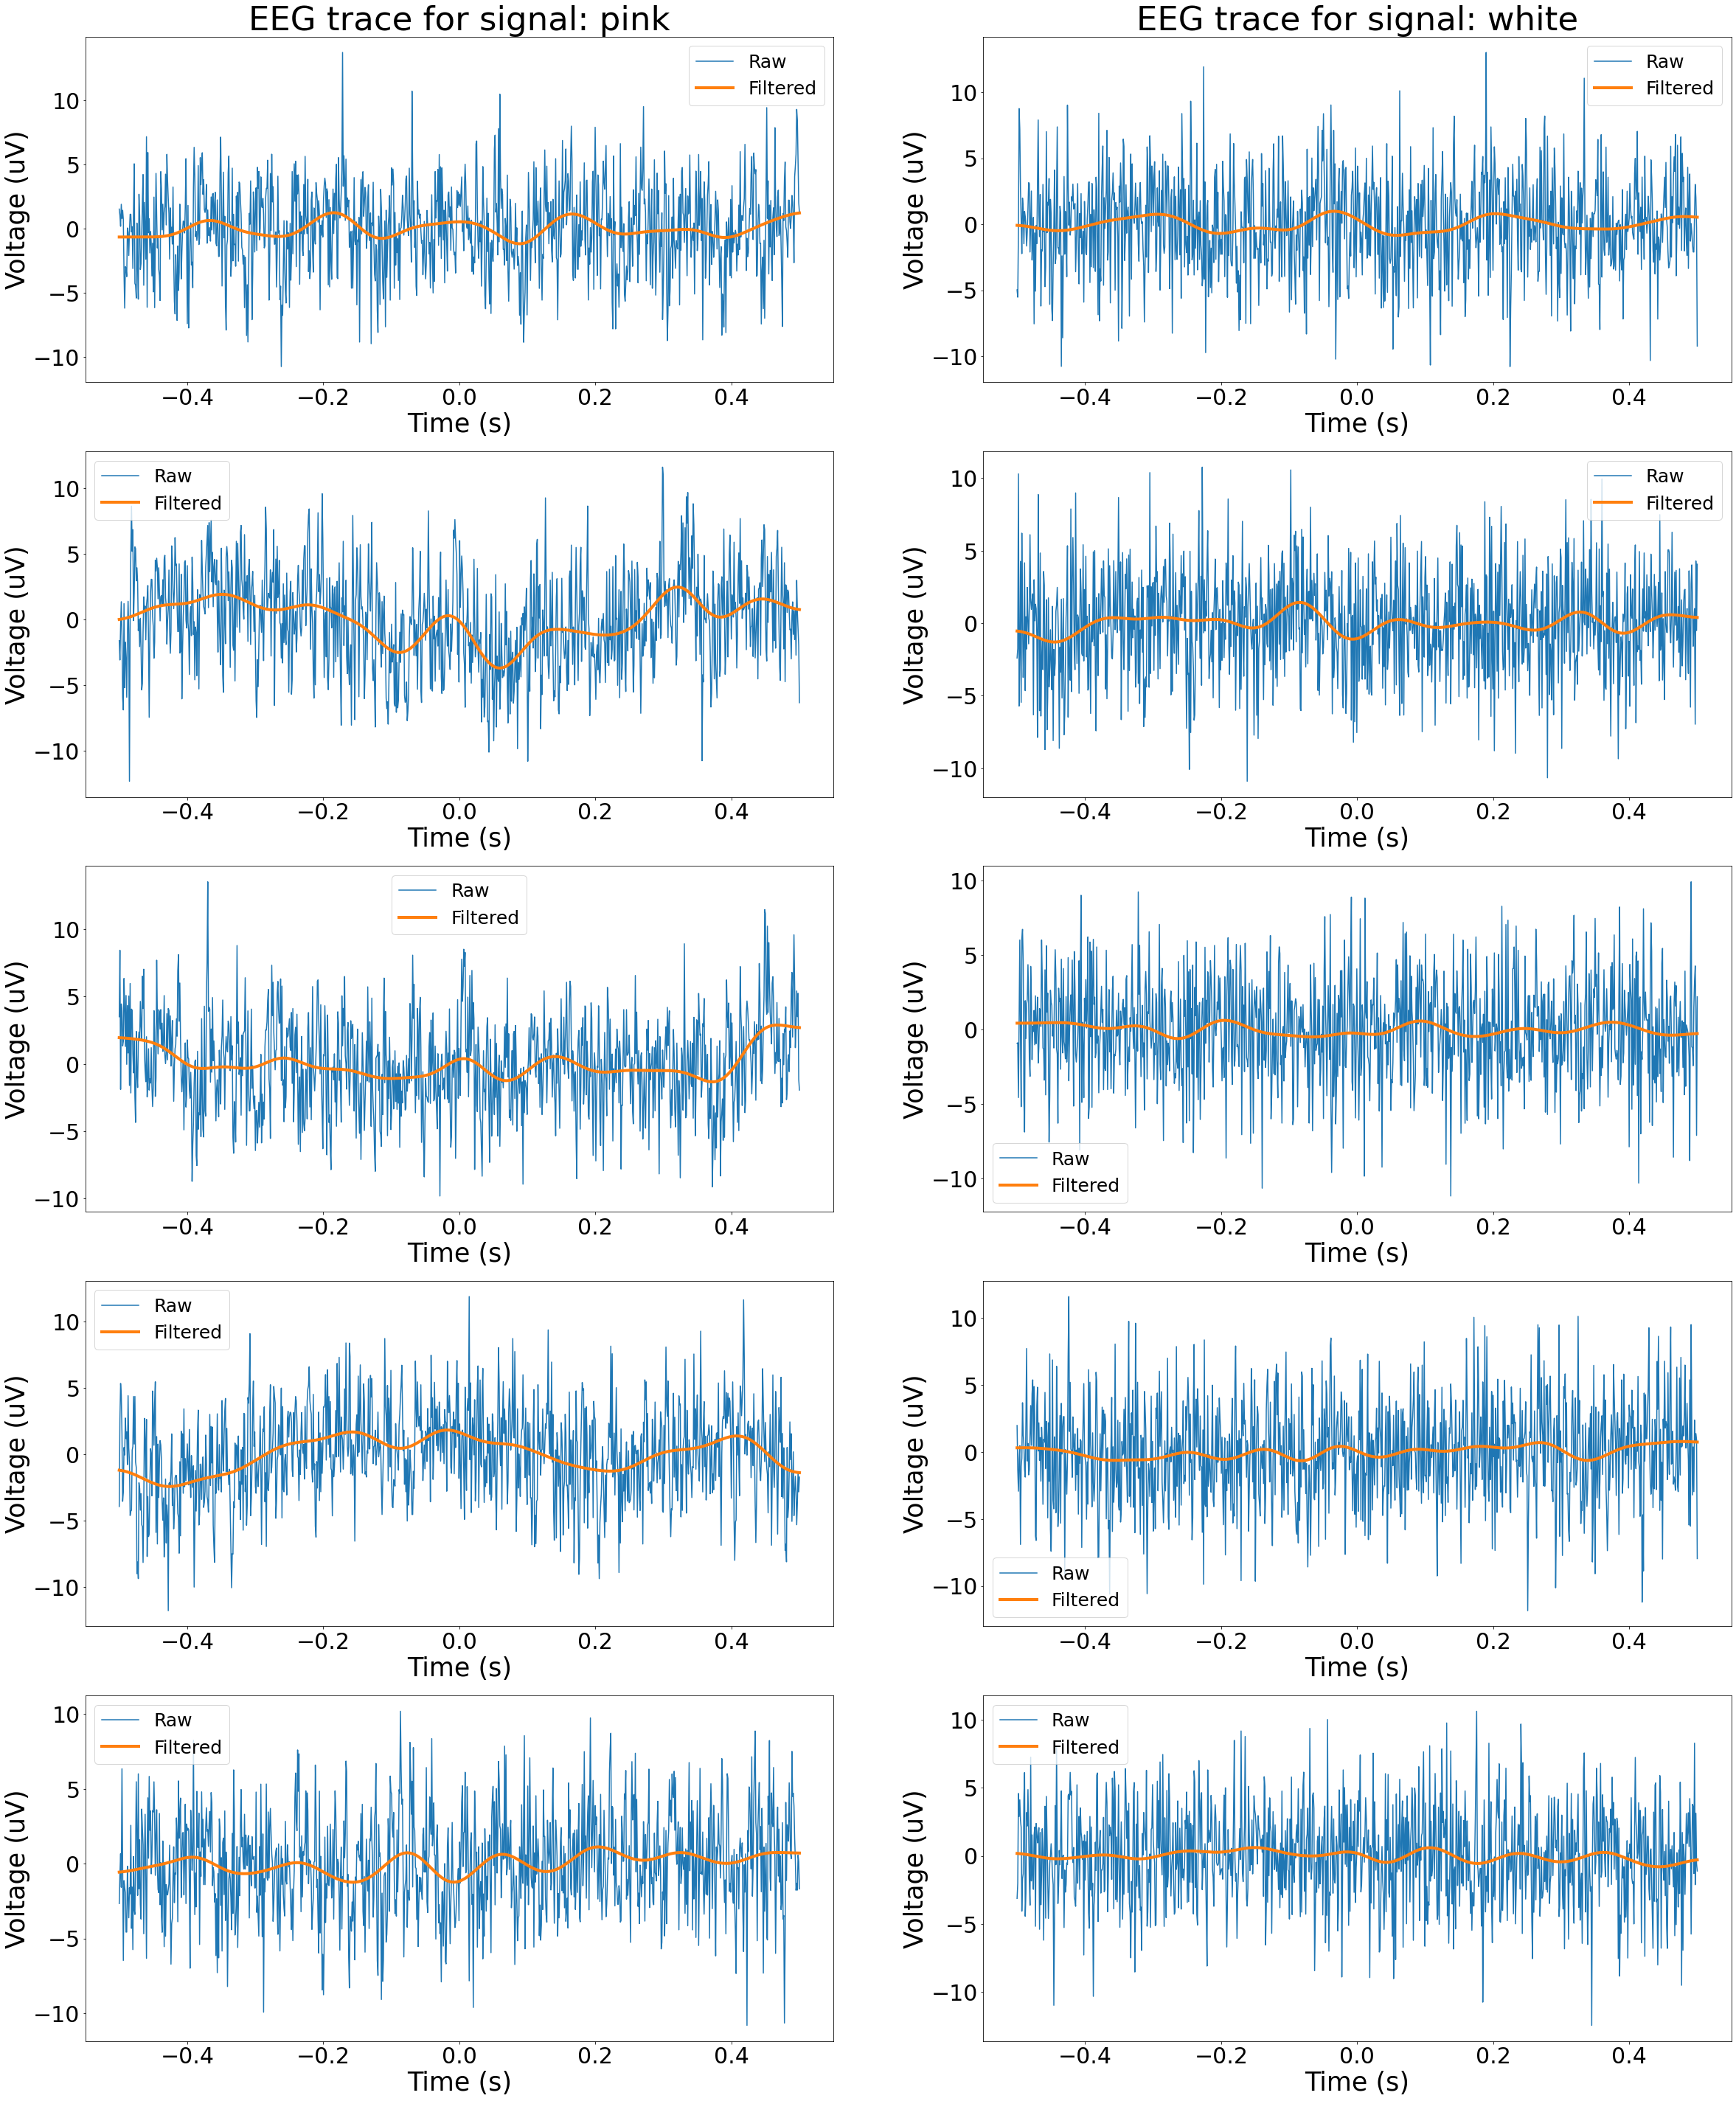

In [10]:
sample_rate = 1000
pink_gen = EEGGen(sampling_rate=sample_rate)
pink_gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=0.51)

white_gen = EEGGen(sampling_rate=sample_rate)
white_gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=0.0)

from scipy import signal
filter_freq = 10  # Hz
b, a = signal.ellip(4, 0.001, 120, filter_freq / sample_rate)

n_evs = 5
gens = {'pink': pink_gen, 'white': white_gen}

duration = 1

n_cols = len(gens)
n_rows = n_evs
from utils import cell_plot_width, fig_height
fig = plt.figure(figsize=(cell_plot_width, fig_height * n_evs))
plt.subplot(n_rows, n_cols, 1)
for ev in range(n_evs):
    for col, (name, gen) in enumerate(gens.items()):
        eeg = generate_eeg_events(gen, n_events=1, duration=duration)
        eeg_filt = signal.filtfilt(b, a, eeg, method="gust")
        time = gen.time_coords - duration / 2.0
        plt.subplot(n_rows, n_cols, ev * n_cols + col + 1)
        plt.plot(time, eeg[0, 0], label='Raw')
        plt.plot(time, eeg_filt[0, 0], linewidth=4, label='Filtered')
        plt.ylabel('Voltage (uV)', fontsize=35)
        plt.xlabel('Time (s)', fontsize=35)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        if (ev * n_cols + col) < n_cols:
            plt.title(f'EEG trace for signal: {name}', fontsize=45)
        plt.legend(fontsize=25)


### Line noise

Most obviously and critically, line noise will show up as strong oscillatory components unrelated to bands of interest (such as the theta band). In particular, line noise will frequently be seen at 
* 60 Hz, the frequency of the US power grid (the European grid hums at 50 Hz)
* At integer multiples (the higher harmonics) of 60 Hz: 120 Hz and 180 Hz
* At integer divisions (the subharmonics) of 60 Hz along with harmonics of the subharmonics: typically 20 Hz and integer multiples of 20 Hz

Line noise can be spotted 
* in the time domain as periodic peaks (which will rise and fall due to the other components in the signal)
    * Given the consistency of the power grid (the primary source of line noise), line noise will typically (but not always) be far more consistent than other signal components
* in the PSD as bumps near the suspicious frequencies.

Line noise is one key form of noise that we need to check for and optimize before making recordings. Some line noise will always be present, but line noise greater than 3 decibels (dB) above the background spectra is cause for concern and can indicate 
* A powerful electrical device is on in the recording room
    * Some other devices are obviously necessary in a clinical setting, but try to remove any that are not needed and pay attention to unusual devices that were not present in previous sessions.
* A faulty grounding connection is in place, which will severely amplify even acceptable amounts of noise
* The universal power supply (UPS) is connected to a wall outlet

1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
LinregressResult(slope=-5.811263628055013, intercept=25.37757319026345, rvalue=-0.6764525434936122, pvalue=7.423129378537462e-100, stderr=0.23321633357634508, intercept_stderr=0.4481749968858234)
dB power at 60 Hz: 15.044267503728442
dB power at 120 Hz: 13.29490283897279
dB power at 180 Hz: 12.271590110004096


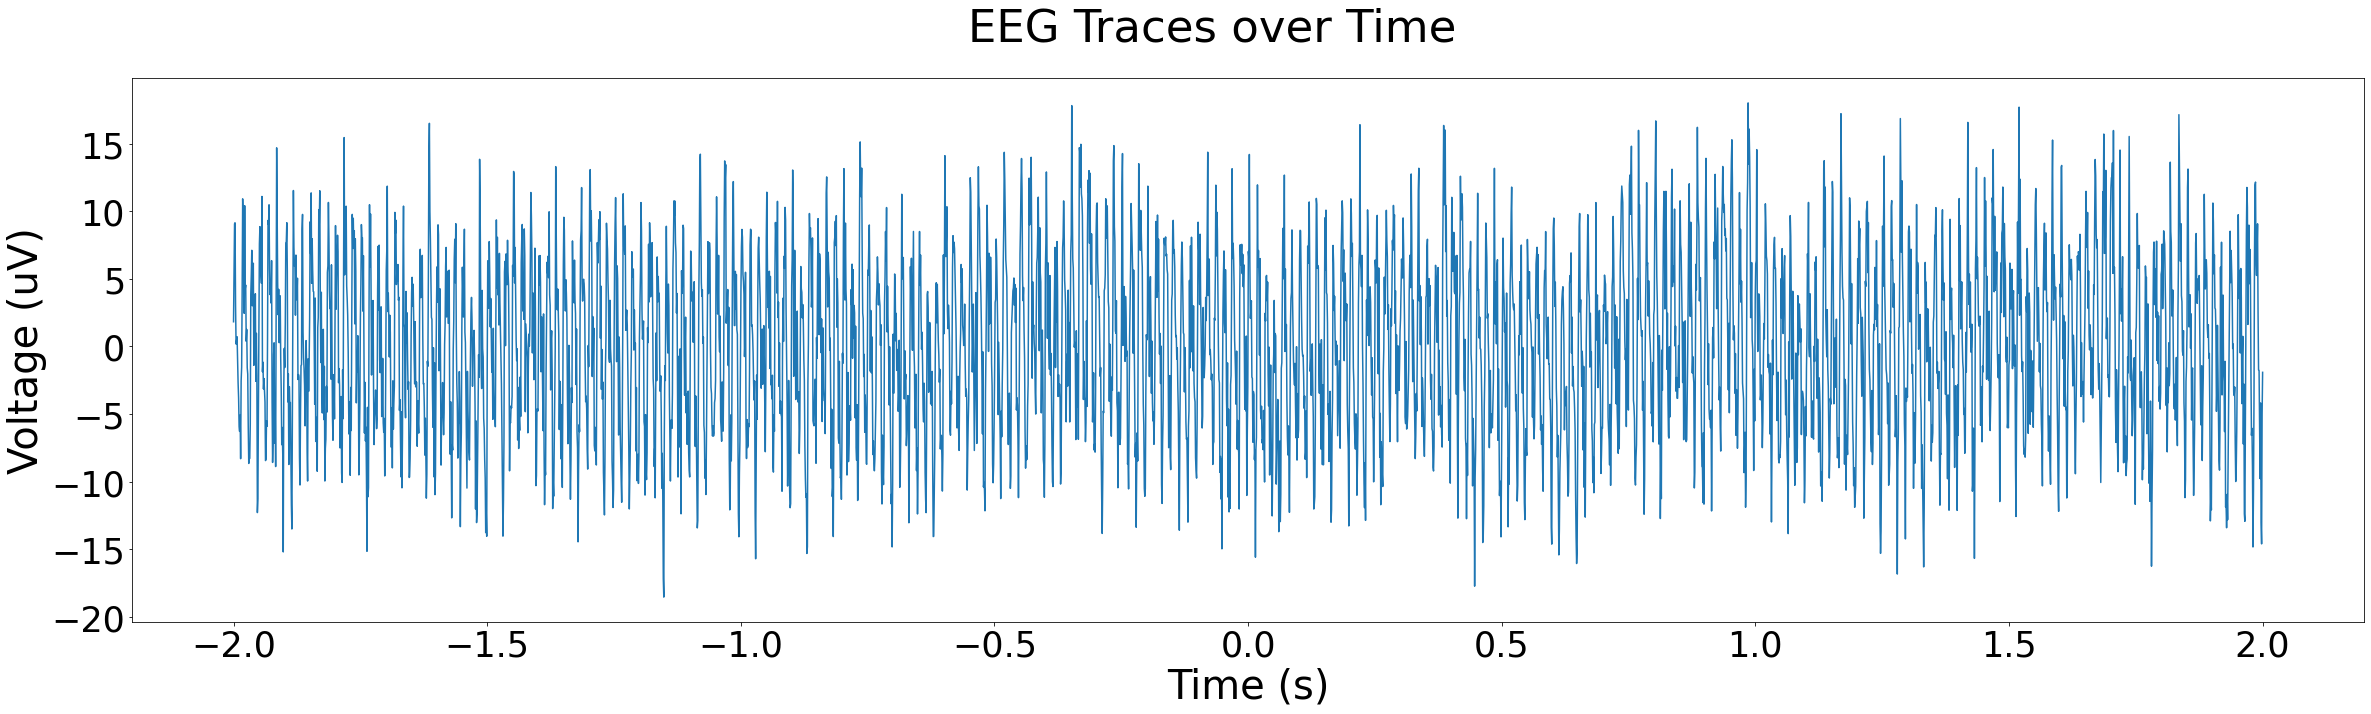

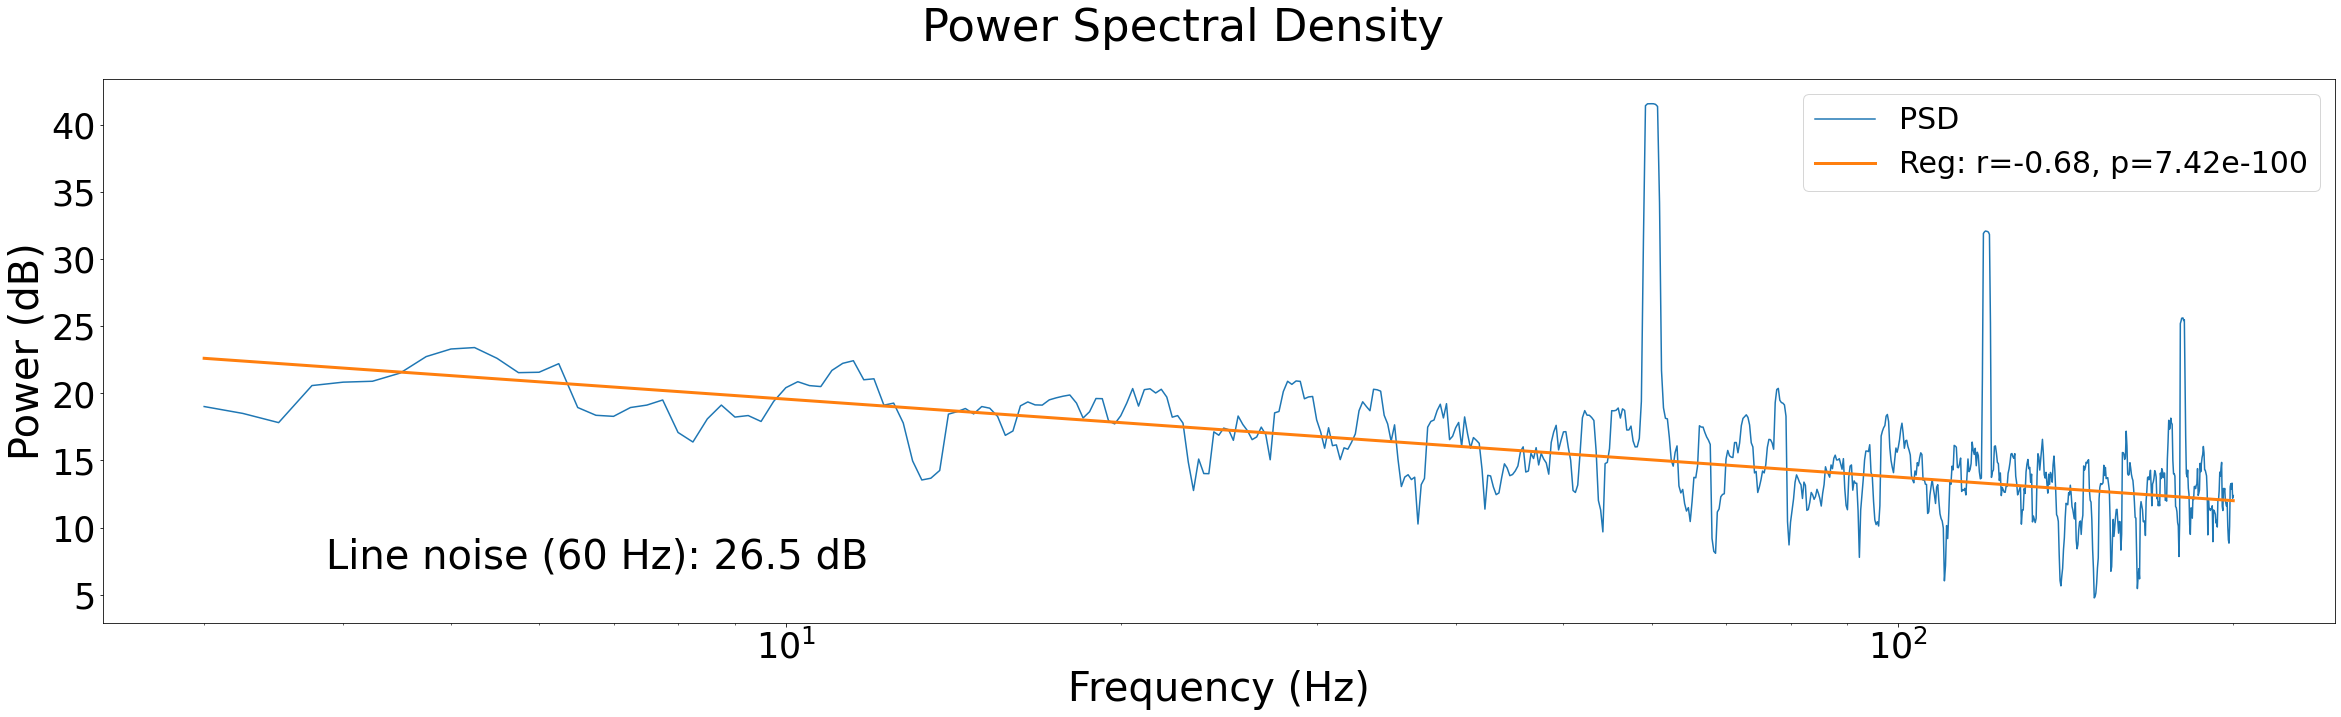

In [11]:
# pink noise spectra with heavy line noise

line_gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
line_gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

duration = 4  # seconds

# line noise components

osc_freq = 60  # Hz
osc_amplitude_scale = 1.0
osc_offset = 0.0
cycles = osc_freq * duration
line_gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

# higher harmonics of 60 Hz
osc_freq = 120  # Hz
osc_amplitude_scale = 0.35
osc_offset = 0.0
cycles = osc_freq * duration
line_gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

osc_freq = 180  # Hz
osc_amplitude_scale = 0.15
osc_offset = 0.0
cycles = osc_freq * duration
line_gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

# 20 Hz subharmonic (quite common)
# osc_freq = 20  # Hz
# osc_amplitude_scale = 0.6
# osc_offset = 0.0
# cycles = osc_freq * duration
# gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

plot_eeg_signal(line_gen, duration=duration, n_events=1, exclude_line_noise=True)

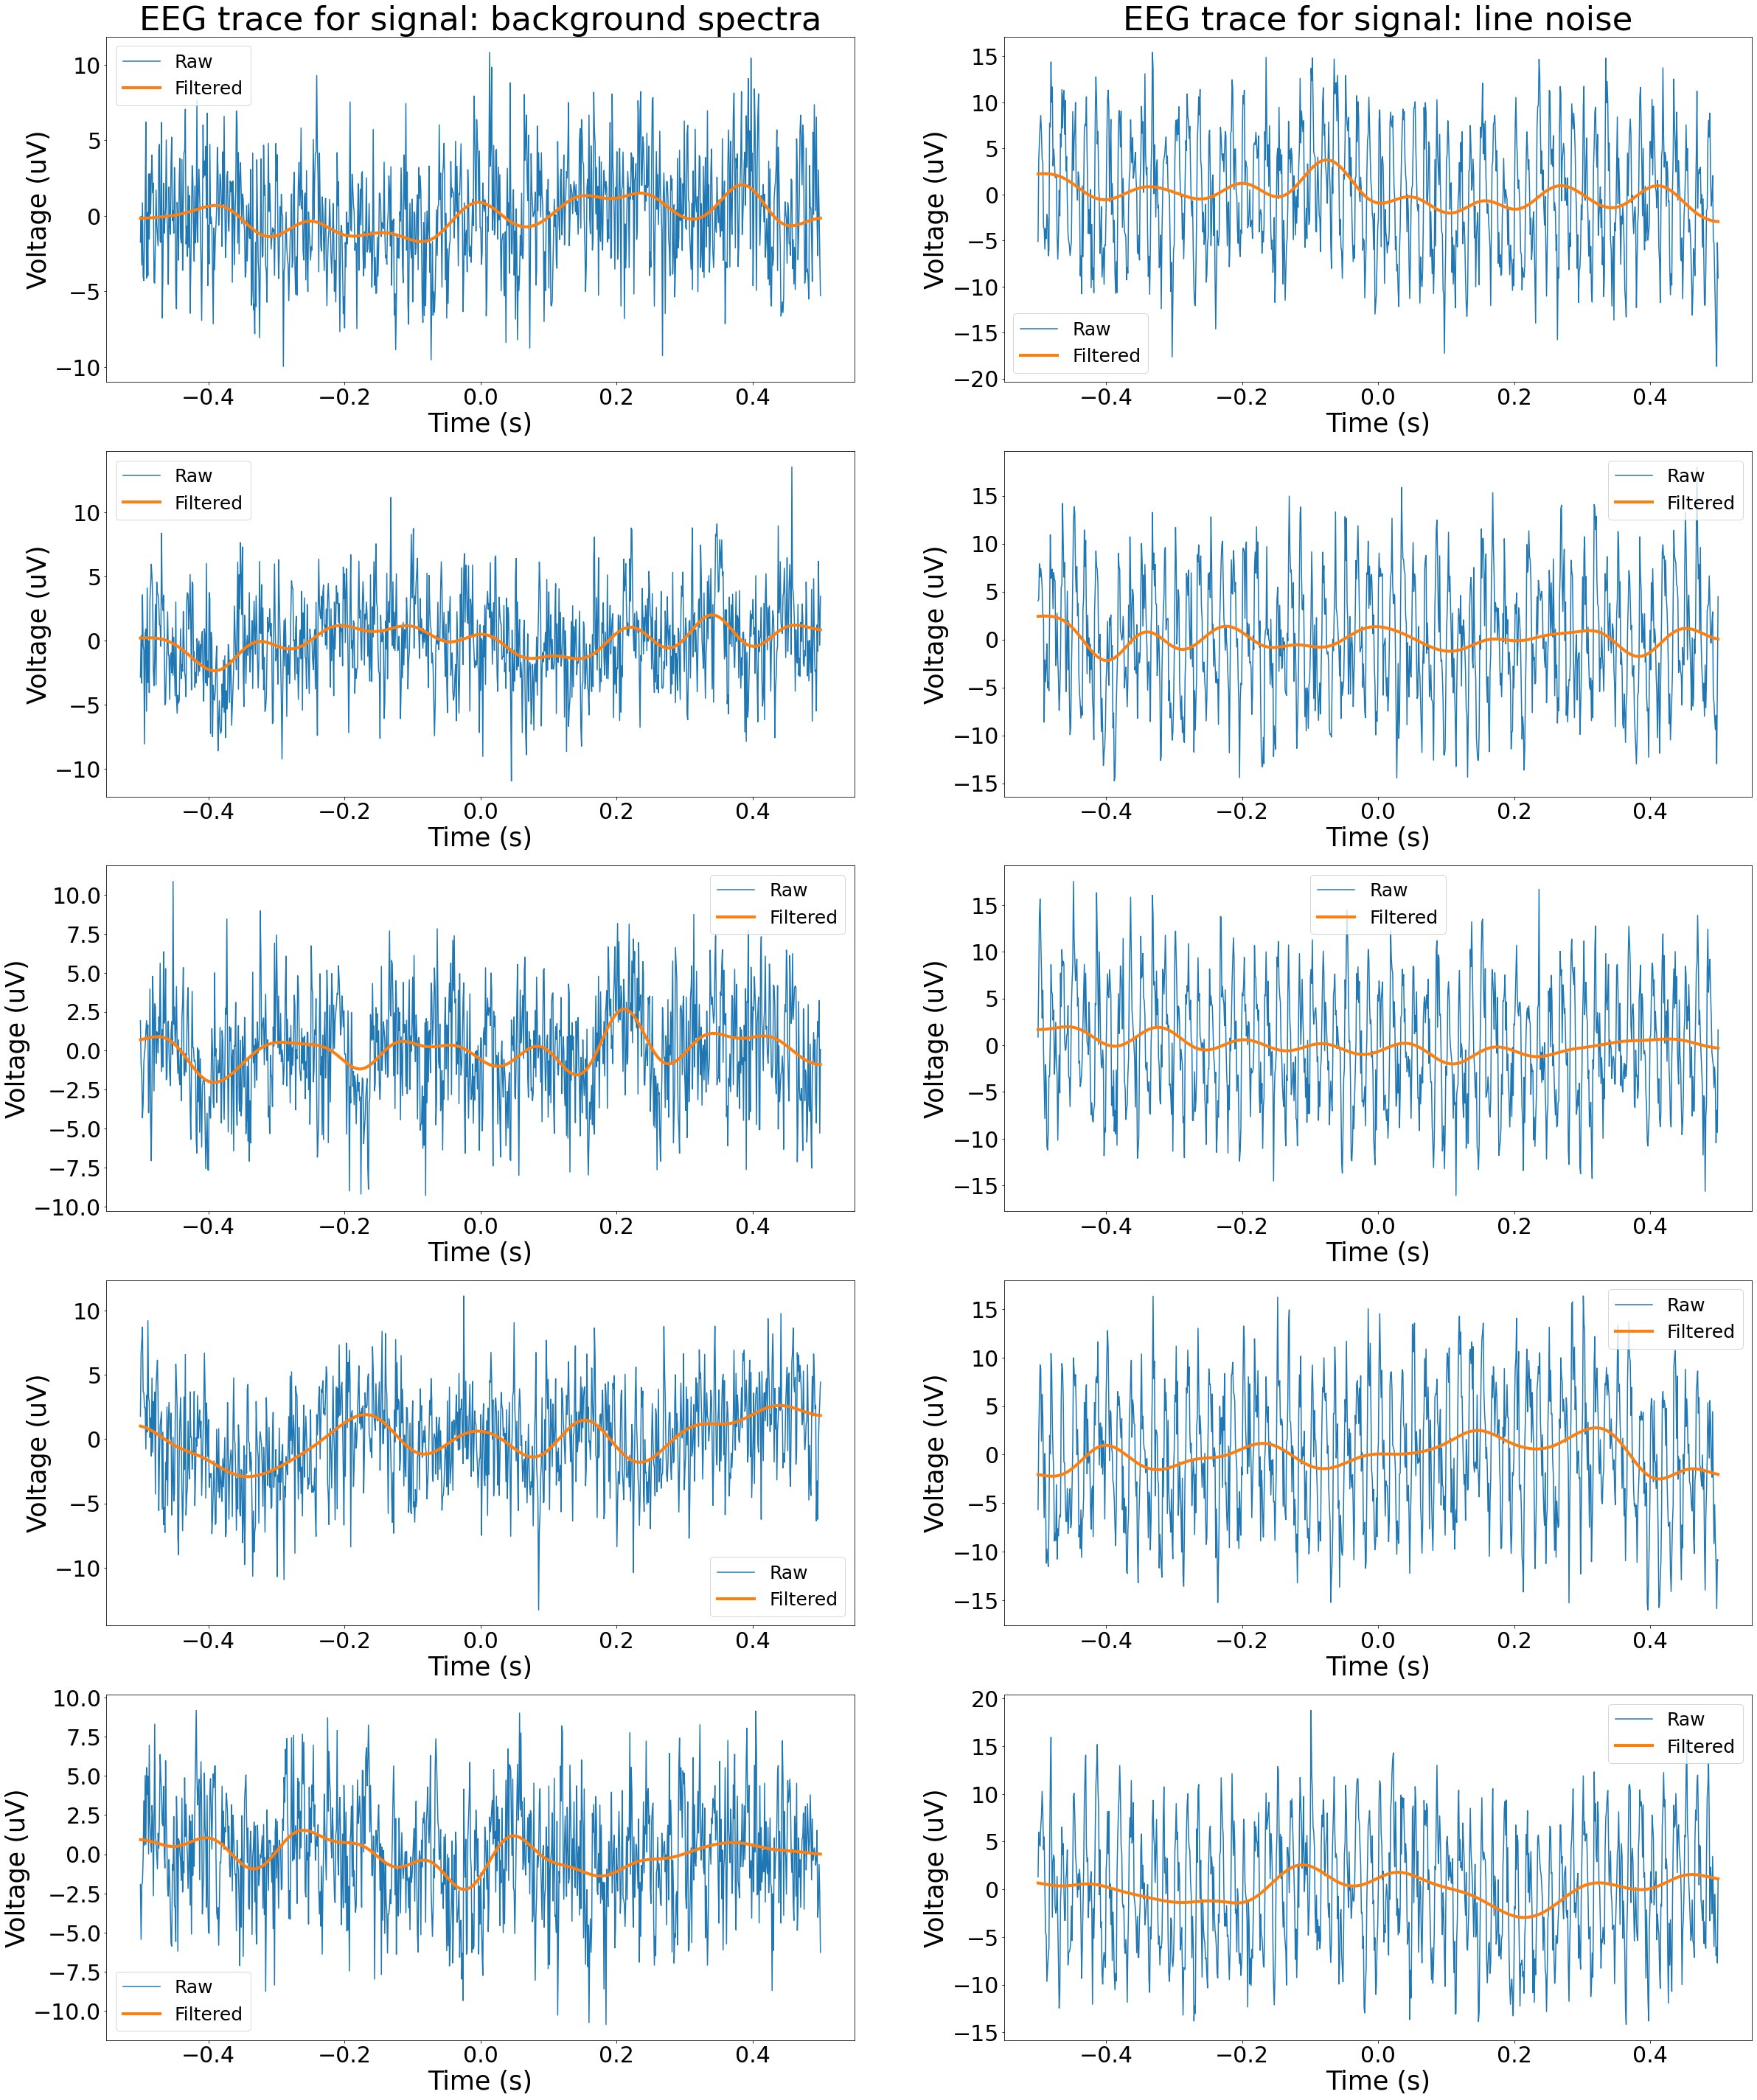

In [12]:
# side-by-side comparison of line noise with normal pink noise
from scipy import signal
filter_freq = 10  # Hz
b, a = signal.ellip(4, 0.001, 120, filter_freq / sample_rate)

n_evs = 5
gens = {'background spectra': pink_gen, 'line noise': line_gen}

duration = 1

n_cols = len(gens)
n_rows = n_evs
fig = plt.figure(figsize=(cell_plot_width, fig_height * n_evs))
plt.subplot(n_rows, n_cols, 1)
for ev in range(n_evs):
    for col, (name, gen) in enumerate(gens.items()):
        eeg = generate_eeg_events(gen, n_events=1, duration=duration)
        eeg_filt = signal.filtfilt(b, a, eeg, method="gust")
        time = gen.time_coords - duration / 2.0
        plt.subplot(n_rows, n_cols, ev * n_cols + col + 1)
        plt.plot(time, eeg[0, 0], label='Raw')
        plt.plot(time, eeg_filt[0, 0], linewidth=4, label='Filtered')
        plt.ylabel('Voltage (uV)', fontsize=35)
        plt.xlabel('Time (s)', fontsize=35)
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        if (ev * n_cols + col) < n_cols:
            plt.title(f'EEG trace for signal: {name}', fontsize=45)
        plt.legend(fontsize=25)


4 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
LinregressResult(slope=-4.698065853456821, intercept=23.698437158222, rvalue=-0.8384561601275583, pvalue=1.353089955912701e-49, stderr=0.22697148167242934, intercept_stderr=0.43558417111061865)
dB power at 60 Hz: 15.344565486513053
dB power at 120 Hz: 13.930306743017848
dB power at 180 Hz: 13.103018411756132


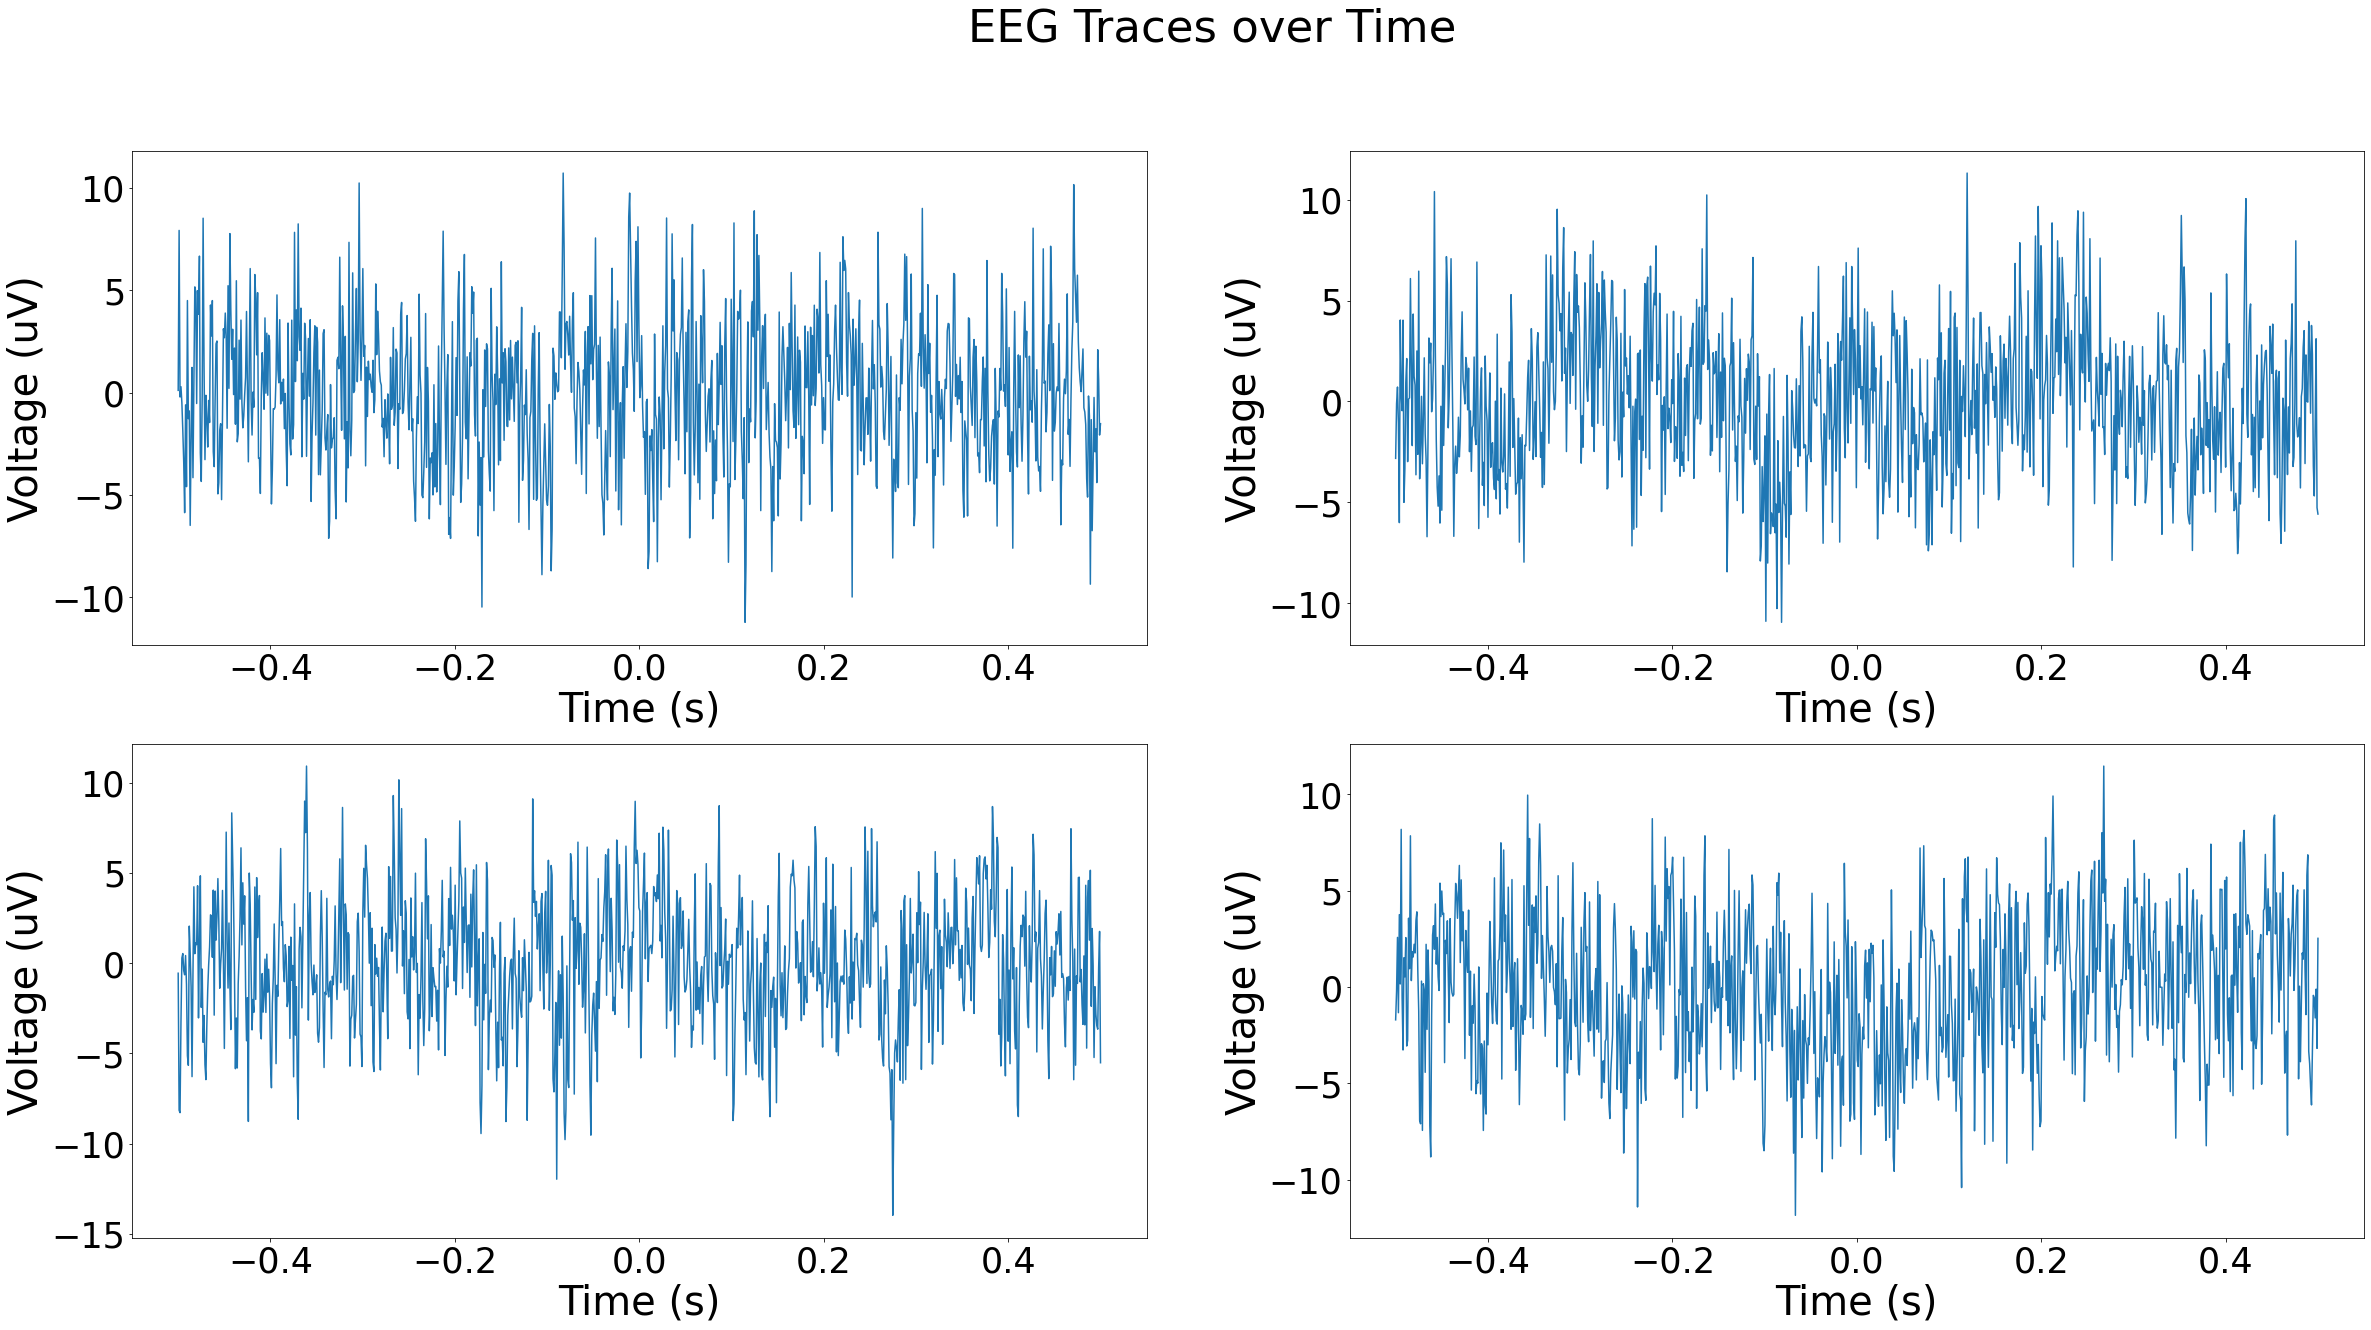

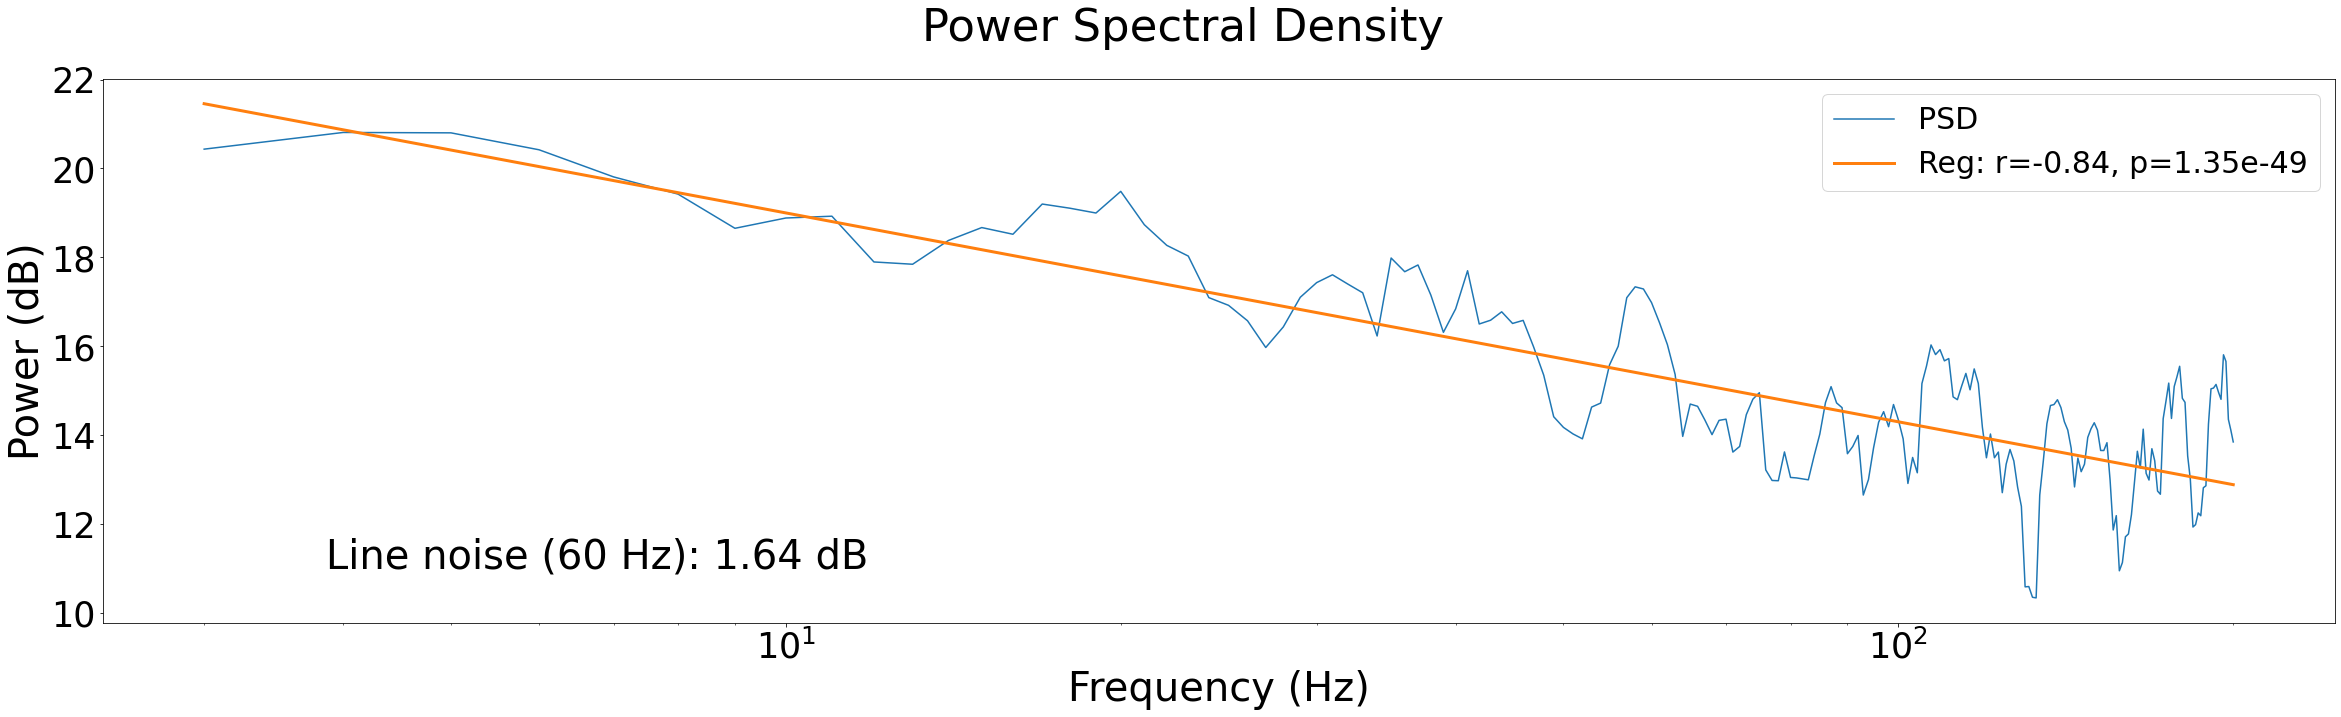

In [13]:
# pink noise spectra with acceptable line noise

gen = EEGGen(sampling_rate=sample_rate)

pink_scale = 0.5
pink_exponent = 0.51  # 0.51 from Linkenkaer-Hansen et al. 2001, J. Neurosci.
gen.EnablePinkNoise(amp=pink_scale * eeg_scale, exponent=pink_exponent)

duration = 1  # seconds

# line noise components
osc_freq = 60  # Hz
osc_amplitude_scale = 0.07
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

osc_freq = 120  # Hz
osc_amplitude_scale = 0.05
osc_offset = 0.0
cycles = osc_freq * duration
gen.AddWave(freq=osc_freq, amp=osc_amplitude_scale * eeg_scale, start=osc_offset, reps=cycles)

plot_eeg_signal(gen, duration=duration, n_events=4, exclude_line_noise=True)

## Line Noise Discrimination Test

Now take the line noise test. You will be shown a series of signals. Signals will either have acceptable or unacceptable amounts of line noise. Respond 'Y' or 'y' (for yes) if a signal has a large amount of line noise or 'N' or 'n' (for no) if not. 

In [ ]:
# Change answer_delay if you want to have more/less time to review the simulated EEG trace after answering each quiz question:
answer_delay = 5  # seconds

from utils import discrimination_quiz, display_quiz_eeg
prompt = 'Does this signal have strong line noise? Type your response (Y/N)'
from functools import partial
display_line_noise = partial(display_quiz_eeg, True)
display_pink_noise = partial(display_quiz_eeg, False)
%matplotlib auto
_ = discrimination_quiz(display_line_noise, display_pink_noise, prompt, 
                        answer_delay=answer_delay)
%matplotlib inline

## Patterns Across Recording Channels (Usually Artifactual):

* Physiological (i.e. clean) EEG is weakly correlated across channels. 
* Atypical patterns can appear in recordings, e.g., due to epileptiform activity. Any unusual patterns that appear on only a single channel, or that slowly spread from one channel to another (which epileptiform activity can do), can largely be ignored. Epileptiform activity will often occur in the theta band.
* If a non-pink-noise signal clearly appears on multiple channels simultaneously, it's highly suspicious and likely indicates artifacts.
* Artifactual signals will usually apear across multiple channels (more than 3) on the same shank. For bipolar montages (the most common configuration that will be viewed on the Elemem and Ramulator EEG trace dashboards), an atypical signal appearing on a single contact can show up on two consecutive bipolar pairs, but this does not necessarily indicate a broader issue with the shank. 
* Artifacts can also appear across multiple shanks or on nearly all shanks.
    * An artifact that occurs on nearly all channels at a single point in time could be due to a spike in electromagnetic interference from a high current device in the room such as a motor. If these are transient, they can be ignored.
* The structure of correlations between contacts provides substantial information as to what is causing a problem. If an unusual signal appears across many contacts for a single shank only, it could indicate that shank has a poor connection (check it is properly plugged in) or needs to be replaced. 
* If a problem is seen across multiple shanks, it indicates something more systematic is going on. Check the entire recording setup for mistakes, loose connections, frayed wires, or damaged plugs. Check the room for new sources of electromagnetic interference, such as large electronic devices such as motors. If a new component has been recently added to the system, such as an extension wire, try removing that component.
* Compare the signals recorded by Elemem or Ramulator to the signals being recorded by the clinical EEG. If the artifacts do not appear in the clinical EEG, it indicates the issue is likely specific to the Blackrock or ENS recording setup. If the artifact is seen in the clinical EEG as well, ask the EEG techs about it.


## Denoising Checklist: What to Do If (and When) You Find Artifacts

1. Double check the setup for mistakes.
    * Connections to the wrong plugs
    * Loose connections (poor connections can manifest in dead/flat signal or white noise)
    * Missing opto-isolator
2. Check the hardware for damage.
    * Frayed wires
    * Broken plugs (e.g. visibly bent wires inside the plug)
3. Check the room for new sources of electromagnetic interference (EMI).
    * Large devices, such as motors (especially when they start up)
4. Check that nothing has been recently added to the setup. If there has been a recent addition (e.g., an extension wire), try removing that component and observing the effect.
5. Compare to the clinical EEG
6. Record a short (~2 minute) task-free EEG snippet on Elemem or ENS to send back to the lab for confirmation of the issue and analysis. To create a non-task EEG recording 
    * in Elemem:
        * Load a config.
            * Do not press "Start Experiment".
        * Instead, press "Stop Experiment" to start the non-task recording.
        * Press "Stop Experiment" again to complete/save/close the recording file.
    * on the ENS:
        * Run any record-only task for two minutes before quitting the task.
    
7. Talk to the EEG techs (who are extremely knowledgeable) for help and information on any known issues.